<a href="https://colab.research.google.com/github/Mohamedelrefaie/TransonicSurrogate/blob/main/AeroPerformancePrediction_Transonic_Regime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


r2_rf_cl:  0.9778114734770905
r2_rf_cm:  0.9891394456257369
r2_gbr_cl:  0.9778114734770905
r2_gbr_cm:  0.9913570255125155
r2_gbm_cl:  0.7942467780743759
r2_gbm_cm:  0.8434395596216244
r2_svr_cl:  0.4020508461553426
r2_svr_cm:  0.08530685415324935
r2_nn_cl:  0.9991801950037317
r2_nn_cm:  0.9988438386265683


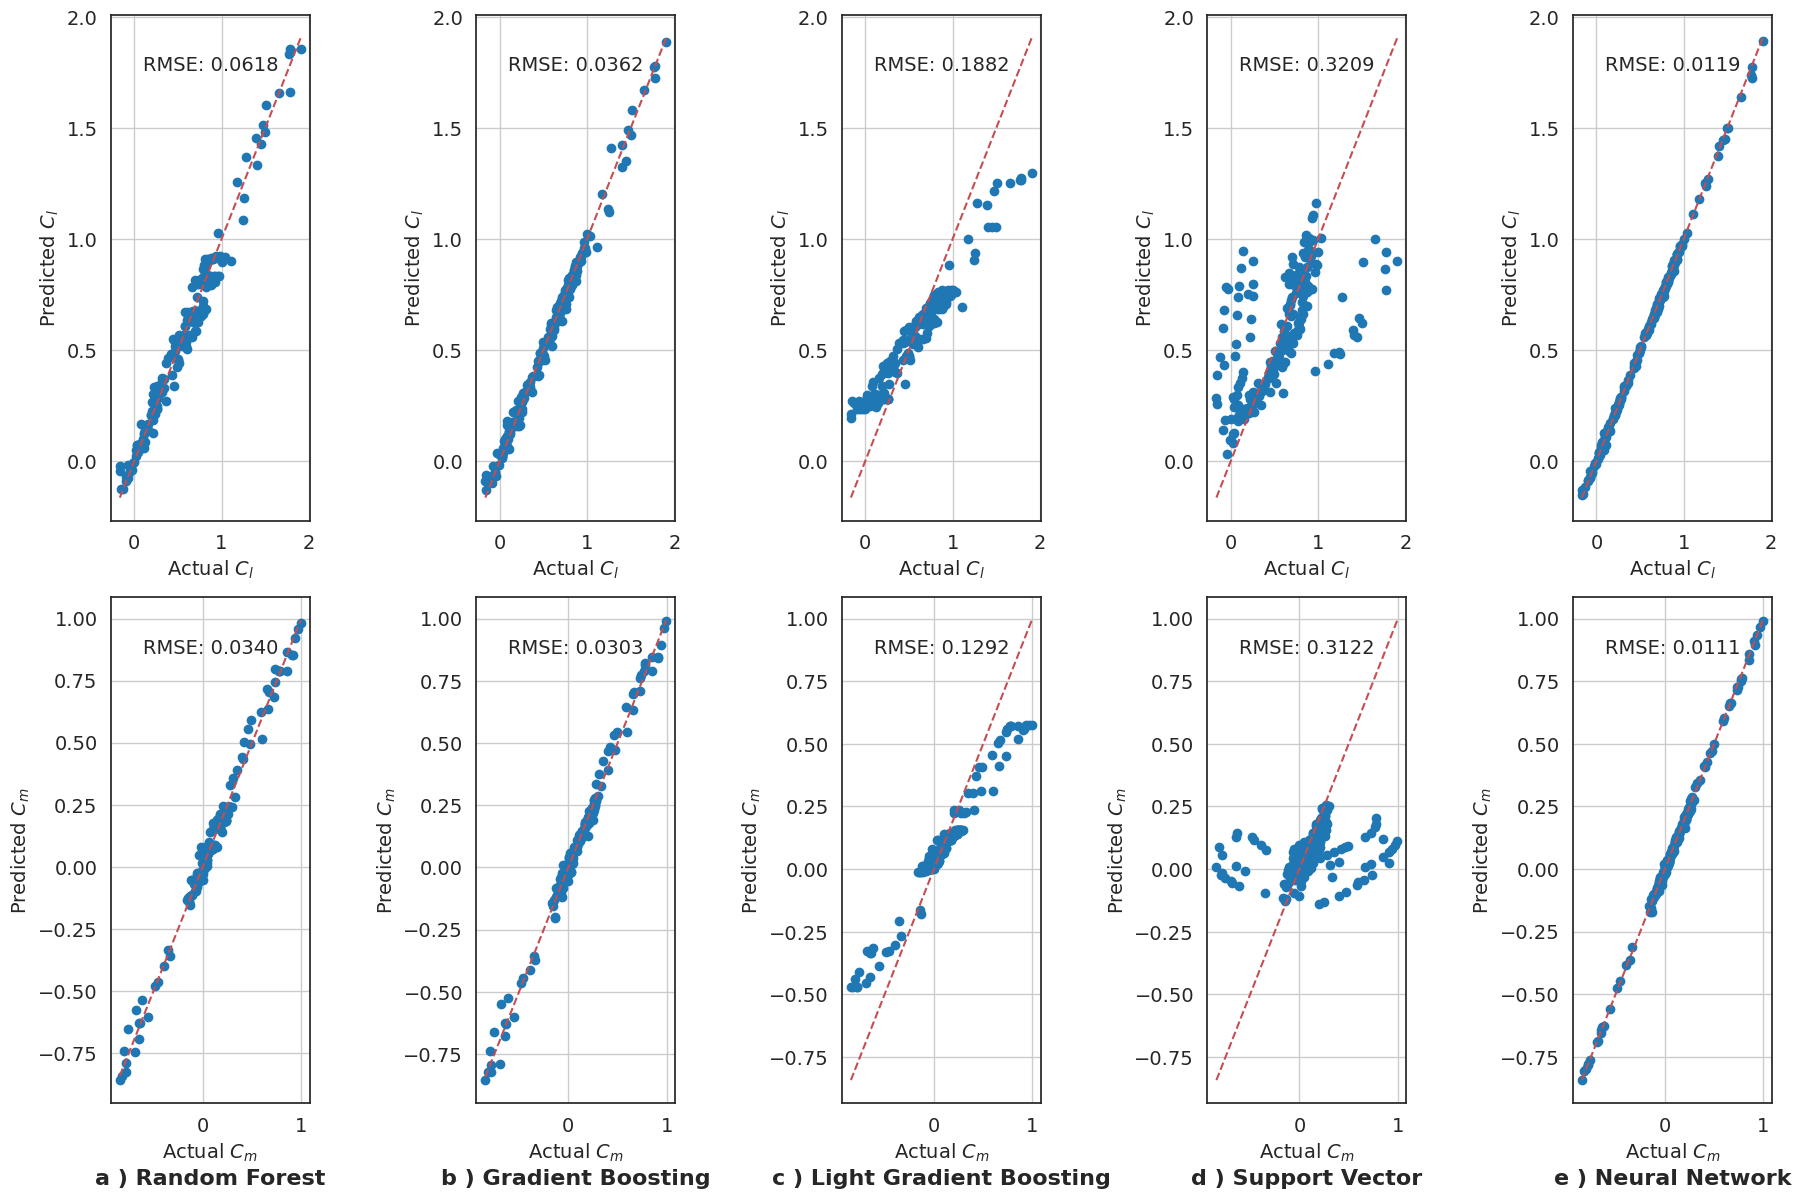

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
from sklearn.svm import SVR
import lightgbm as lgb
from sklearn.metrics import r2_score


# Load the CSV file
csv_file_path = '/content/drive/MyDrive/DATA_MODIFIED.csv'
df = pd.read_csv(csv_file_path)

# Define the features and target variables
features = ['y_U1', 'y_U2', 'y_U3', 'y_U4', 'y_U5', 'y_U6', 'y_U7', 'y_U8',
            'y_L1', 'y_L2', 'y_L3', 'y_L4', 'y_L5', 'y_L6', 'y_L7', 'y_L8',
            'alpha', 'Mach']

# Split the data into train, validation, and test sets
X_train, X_temp, y_train_cl, y_temp_cl = train_test_split(df[features], df['Cl'], test_size=0.3, random_state=42)
X_val, X_test, y_val_cl, y_test_cl = train_test_split(X_temp, y_temp_cl, test_size=0.5, random_state=42)
_, _, y_train_cm, y_temp_cm = train_test_split(df[features], df['Cm'], test_size=0.3, random_state=42)
_, _, y_val_cm, y_test_cm = train_test_split(X_temp, y_temp_cm, test_size=0.5, random_state=42)

# Train Random Forest Regressor for Cl and Cm
rf_model_cl = RandomForestRegressor(n_estimators=100, max_depth=6)
rf_model_cl.fit(X_train, y_train_cl)
rf_model_cm = RandomForestRegressor(n_estimators=100, max_depth=6)
rf_model_cm.fit(X_train, y_train_cm)

# Train Gradient Boosting Regressor for Cl and Cm
gbr_model_cl = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
gbr_model_cl.fit(X_train, y_train_cl)
gbr_model_cm = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
gbr_model_cm.fit(X_train, y_train_cm)

# Train the SVR model
svr_model_cl = SVR(kernel='linear', degree=5)  # You can choose different kernels like 'linear', 'poly', 'rbf'
svr_model_cl.fit(X_train, y_train_cl)  # Assuming y_train_cl is a 1D array
svr_model_cm = SVR(kernel='linear', degree=5 )
svr_model_cm.fit(X_train, y_train_cm)

# Train the lgb model
# Prepare the dataset for LightGBM
lgb_train_cl = lgb.Dataset(X_train, y_train_cl)  # Assuming y_train_cl is a 1D array
lgb_train_cm = lgb.Dataset(X_train, y_train_cm)  # Assuming y_train_cm is a 1D array

# Specify your configurations as a dictionary
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 10,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train the model
lgb_model_cl = lgb.train(params, lgb_train_cl, num_boost_round=20)
lgb_model_cm = lgb.train(params, lgb_train_cm, num_boost_round=20)


# Prepare PyTorch datasets and loaders for the neural network
batch_size = 32
train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32),
                              torch.tensor(np.vstack((y_train_cl, y_train_cm)).T, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(torch.tensor(X_val.values, dtype=torch.float32),
                            torch.tensor(np.vstack((y_val_cl, y_val_cm)).T, dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Neural Network for Regression
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(len(features), 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)  # Output size is 2 for 'Cl' and 'Cm'

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RegressionNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Neural Network Training and Validation Loop
num_epochs = 500
model.train()
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Validation step
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
    val_loss /= len(val_loader)
    #print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

# Prepare test data and evaluate models
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor_cl = torch.tensor(y_test_cl.values, dtype=torch.float32).to(device)
y_test_tensor_cm = torch.tensor(y_test_cm.values, dtype=torch.float32).to(device)

# Evaluate Random Forest, Gradient Boosting, and SVR
Y_pred_rf_cl = rf_model_cl.predict(X_test)
Y_pred_rf_cm = rf_model_cm.predict(X_test)
rmse_rf_cl = np.sqrt(mean_squared_error(y_test_cl, Y_pred_rf_cl))
rmse_rf_cm = np.sqrt(mean_squared_error(y_test_cm, Y_pred_rf_cm))

Y_pred_gbr_cl = gbr_model_cl.predict(X_test)
Y_pred_gbr_cm = gbr_model_cm.predict(X_test)
rmse_gbr_cl = np.sqrt(mean_squared_error(y_test_cl, Y_pred_gbr_cl))
rmse_gbr_cm = np.sqrt(mean_squared_error(y_test_cm, Y_pred_gbr_cm))

Y_pred_svr_cl = svr_model_cl.predict(X_test)
Y_pred_svr_cm = svr_model_cm.predict(X_test)
rmse_svr_cl = np.sqrt(mean_squared_error(y_test_cl, Y_pred_svr_cl))
rmse_svr_cm = np.sqrt(mean_squared_error(y_test_cm, Y_pred_svr_cm))

Y_pred_lgb_cl = lgb_model_cl.predict(X_test)
Y_pred_lgb_cm = lgb_model_cm.predict(X_test)
rmse_gbm_cl = np.sqrt(mean_squared_error(y_test_cl, Y_pred_lgb_cl))
rmse_gbm_cm = np.sqrt(mean_squared_error(y_test_cm, Y_pred_lgb_cm))


model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test_tensor).cpu().numpy()
rmse_nn_cl = np.sqrt(mean_squared_error(y_test_cl, y_pred_nn[:, 0]))
rmse_nn_cm = np.sqrt(mean_squared_error(y_test_cm, y_pred_nn[:, 1]))


# R2 scores for Random Forest
r2_rf_cl = r2_score(y_test_cl, Y_pred_rf_cl)
r2_rf_cm = r2_score(y_test_cm, Y_pred_rf_cm)
print("r2_rf_cl: ", r2_rf_cl)
print("r2_rf_cm: ", r2_rf_cm)

# R2 scores for Gradient Boosting
r2_gbr_cl = r2_score(y_test_cl, Y_pred_gbr_cl)
r2_gbr_cm = r2_score(y_test_cm, Y_pred_gbr_cm)
print("r2_gbr_cl: ", r2_rf_cl)
print("r2_gbr_cm: ", r2_gbr_cm)

# R2 scores for Light Gradient Boosting
r2_gbm_cl = r2_score(y_test_cl, Y_pred_lgb_cl)
r2_gbm_cm = r2_score(y_test_cm, Y_pred_lgb_cm)
print("r2_gbm_cl: ", r2_gbm_cl)
print("r2_gbm_cm: ", r2_gbm_cm)

# R2 scores for Support Vector Regression
r2_svr_cl = r2_score(y_test_cl, Y_pred_svr_cl)
r2_svr_cm = r2_score(y_test_cm, Y_pred_svr_cm)
print("r2_svr_cl: ", r2_svr_cl)
print("r2_svr_cm: ", r2_svr_cm)

# R2 scores for Neural Network
r2_nn_cl = r2_score(y_test_cl, y_pred_nn[:, 0])
r2_nn_cm = r2_score(y_test_cm, y_pred_nn[:, 1])
print("r2_nn_cl: ", r2_nn_cl)
print("r2_nn_cm: ", r2_nn_cm)




# Visualization of results
fig, axs = plt.subplots(2, 5, figsize=(18, 12))
model_names = ['Random Forest', 'Gradient Boosting', 'Light Gradient Boosting', 'Support Vector', 'Neural Network']
predictions_cl = [Y_pred_rf_cl, Y_pred_gbr_cl, Y_pred_lgb_cl, Y_pred_svr_cl, y_pred_nn[:, 0]]
predictions_cm = [Y_pred_rf_cm, Y_pred_gbr_cm, Y_pred_lgb_cm, Y_pred_svr_cm, y_pred_nn[:, 1]]
rmses_cl = [rmse_rf_cl, rmse_gbr_cl, rmse_gbm_cl, rmse_svr_cl, rmse_nn_cl]
rmses_cm = [rmse_rf_cm, rmse_gbr_cm, rmse_gbm_cm, rmse_svr_cm, rmse_nn_cm]

letters = ['a', 'b', 'c', 'd', 'e']

for i in range(len(model_names)):
    # Cl
    axs[0, i].scatter(y_test_cl, predictions_cl[i])
    axs[0, i].plot([y_test_cl.min(), y_test_cl.max()], [y_test_cl.min(), y_test_cl.max()], 'r--')
    axs[0, i].set_xlabel('Actual $C_l$', fontsize=14)
    axs[0, i].set_ylabel('Predicted $C_l$', fontsize=14)
    axs[0, i].tick_params(axis='both', labelsize=14)  # Set tick font size
    axs[0, i].text(0.5, 0.9, f"RMSE: {rmses_cl[i]:.4f}", fontsize=14, ha='center', va='center', transform=axs[0, i].transAxes)
    #axs[0, i].text(0.5, -0.15, model_names[i], fontsize=16, ha='center', va='center', transform=axs[0, i].transAxes)
    axs[0, i].grid()

    # Cm
    axs[1, i].scatter(y_test_cm, predictions_cm[i])
    axs[1, i].plot([y_test_cm.min(), y_test_cm.max()], [y_test_cm.min(), y_test_cm.max()], 'r--')
    axs[1, i].set_xlabel('Actual $C_m$', fontsize=14)
    axs[1, i].set_ylabel('Predicted $C_m$', fontsize=14)
    axs[1, i].tick_params(axis='both', labelsize=14)  # Set tick font size
    axs[1, i].text(0.5, 0.9, f"RMSE: {rmses_cm[i]:.4f}", fontsize=14, ha='center', va='center', transform=axs[1, i].transAxes)
    axs[1, i].text(0.5, -0.15, f"{letters[i]} ) {model_names[i]}", fontsize=16, ha='center', va='center', transform=axs[1, i].transAxes,fontweight='bold')
    axs[1, i].grid()

plt.tight_layout()
plt.show()



#axes[1].text(0.5, -0.15, 'b) Train, Test, Validation Distribution of $C_m$', ha='center', va='center', fontsize=16, transform=axes[1].transAxes)




Target Variable: Cl
Mean Absolute Error: 0.024807948819206994
R-squared: 0.9925047508793168


Target Variable: Cm
Mean Absolute Error: 0.022299577510157452
R-squared: 0.9912799138879645




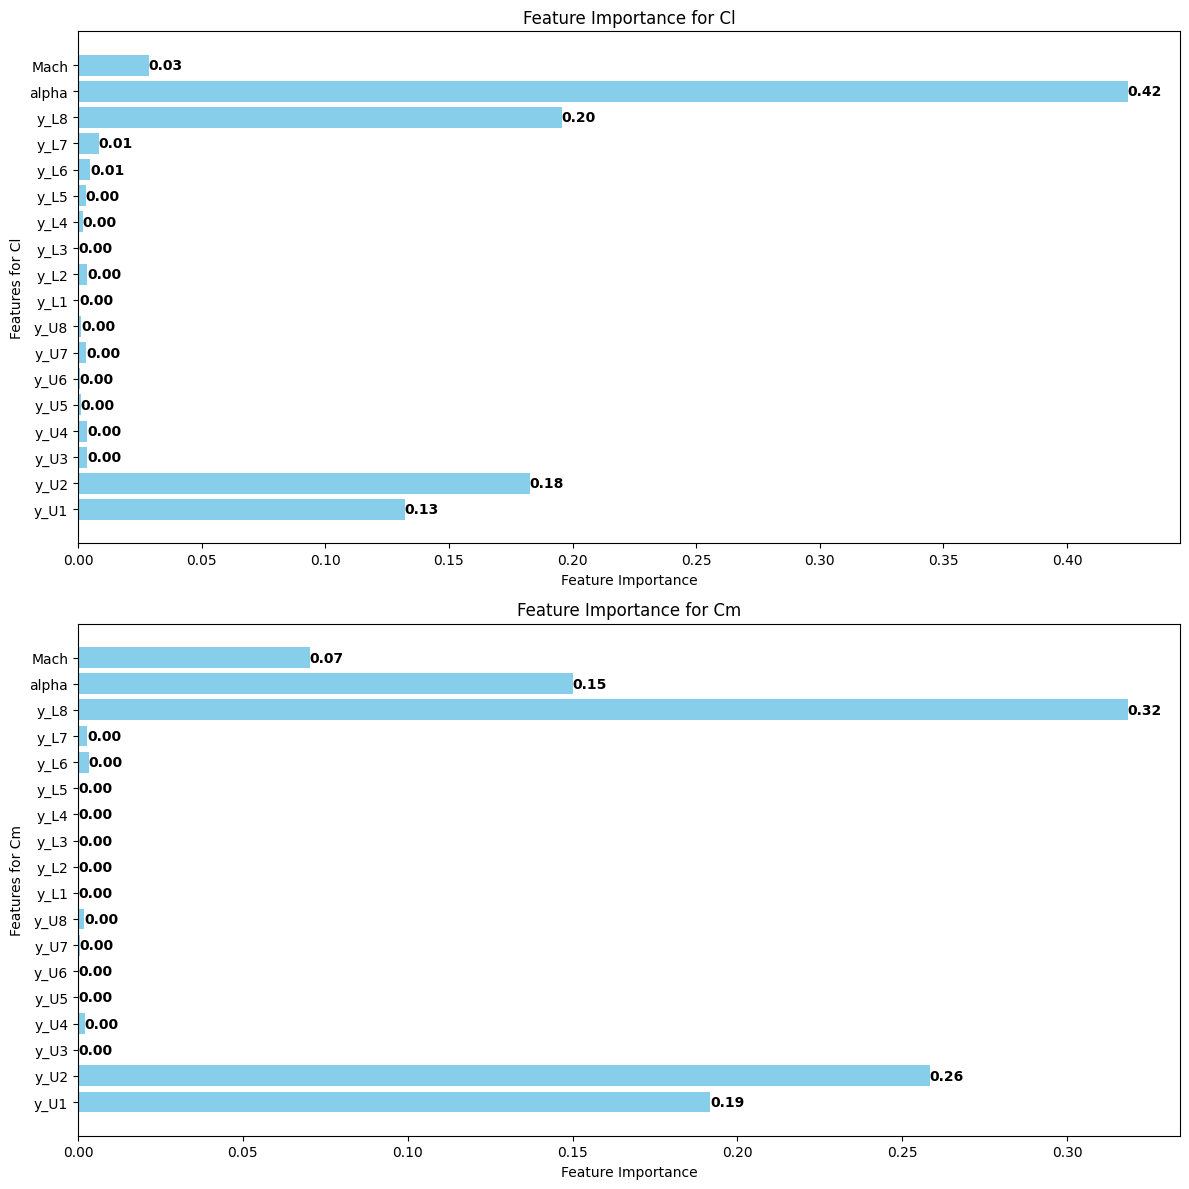

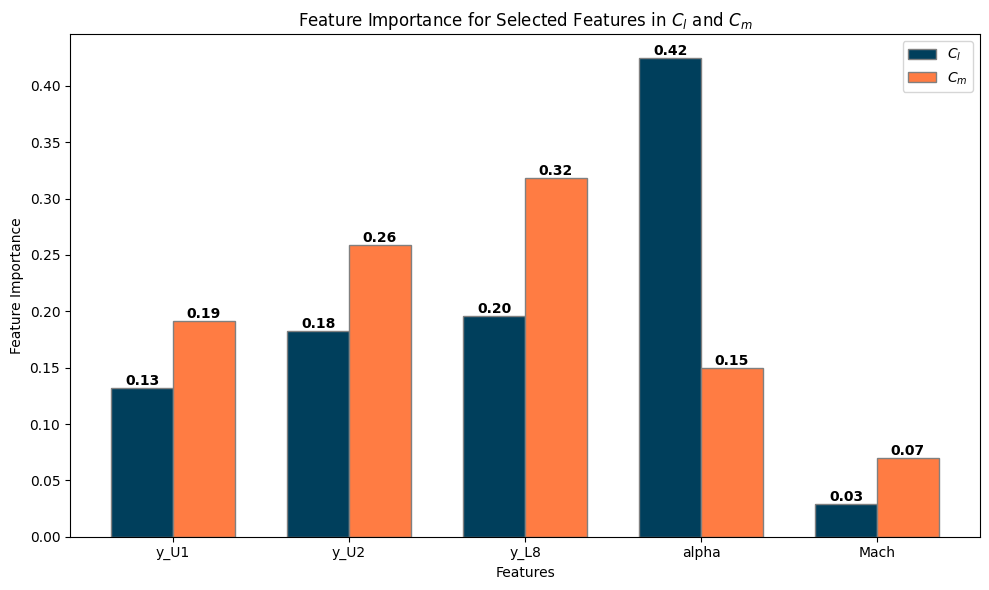

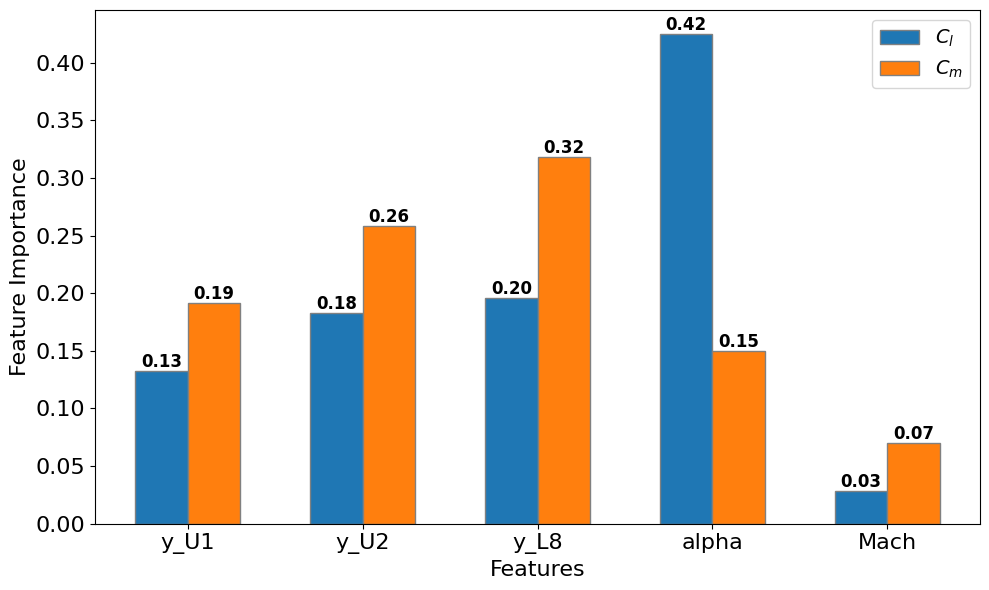

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Load the CSV file
csv_file_path = '/content/drive/MyDrive/DATA_MODIFIED.csv'
df = pd.read_csv(csv_file_path)

# Define features and target variables
features = ['y_U1', 'y_U2', 'y_U3', 'y_U4', 'y_U5', 'y_U6', 'y_U7', 'y_U8',
            'y_L1', 'y_L2', 'y_L3', 'y_L4', 'y_L5', 'y_L6', 'y_L7', 'y_L8',
            'alpha', 'Mach']
target_variables = ['Cl', 'Cm']

# Initialize dictionaries to store models, predictions, and feature importances
models = {}
predictions = {}
feature_importance = {}

# Loop through each target variable and create a model
for target_variable in target_variables:
    Y = df[target_variable]
    X = df[features]

    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Create a GradientBoostingRegressor
    model = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)

    # Train the model
    model.fit(X_train, Y_train)

    # Make predictions on the test set
    Y_pred = model.predict(X_test)

    # Store the model and predictions
    models[target_variable] = model
    predictions[target_variable] = (Y_test, Y_pred)

    # Get feature importance and store it
    importance = model.feature_importances_
    feature_importance[target_variable] = importance

    # Evaluate the model's performance
    mae = mean_absolute_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)

    print(f"Target Variable: {target_variable}")
    print("Mean Absolute Error:", mae)
    print("R-squared:", r2)
    print("\n")

import matplotlib.pyplot as plt

# Assuming 'feature_importance' is a dictionary with keys 'Cl' and 'Cm'
# And 'features' is your list of feature names

fig, axs = plt.subplots(2, 1, figsize=(12, 12))  # Two subplots, one for each target variable

for i, target_variable in enumerate(target_variables):
    importance = feature_importance[target_variable]

    axs[i].barh(features, importance, color='skyblue')
    axs[i].set_xlabel('Feature Importance')
    axs[i].set_title(f'Feature Importance for {target_variable}')

    # Adding text annotations for importance values
    for j, v in enumerate(importance):
        axs[i].text(v, j, f'{v:.2f}', va='center', fontsize=10, color='black', fontweight='bold')

# Setting labels for the y-axis
axs[0].set_ylabel('Features for Cl')
axs[1].set_ylabel('Features for Cm')

plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# Assuming 'feature_importance' is a dictionary with keys 'Cl' and 'Cm'
# And 'features' is your list of feature names

# Width of the bars in the bar chart
barWidth = 0.35

# Set position of bar on X axis
r1 = np.arange(len(features))
r2 = [x + barWidth for x in r1]

#plt.figure(figsize=(12, 6))

# Make the plot
#plt.bar(r1, feature_importance['Cl'], color='blue', width=barWidth, edgecolor='grey', label='Cl')
#plt.bar(r2, feature_importance['Cm'], color='green', width=barWidth, edgecolor='grey', label='Cm')

"""
# Add text annotations for importance values
for i in range(len(features)):
    plt.text(r1[i] - barWidth/2, feature_importance['Cl'][i], f'{feature_importance["Cl"][i]:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.text(r2[i] + barWidth/2, feature_importance['Cm'][i], f'{feature_importance["Cm"][i]:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add xticks on the middle of the group bars
plt.xlabel('Features', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(len(features))], features)

plt.ylabel('Feature Importance')
plt.title('Feature Importance for Cl and Cm')

plt.legend()
plt.tight_layout()
plt.show()
"""


import numpy as np
import matplotlib.pyplot as plt

# List of specific features you want to plot
selected_features = ['y_U1', 'y_U2', 'y_L8', 'alpha','Mach']

# Filter the feature importances for the selected features
selected_importance_cl = [feature_importance['Cl'][features.index(f)] for f in selected_features if f in features]
selected_importance_cm = [feature_importance['Cm'][features.index(f)] for f in selected_features if f in features]

barWidth = 0.35
r1 = np.arange(len(selected_features))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(10, 6))

# Choose your preferred color pair from the options above
colors_cl = '#003f5c'  # Replace with your chosen color for Cl
colors_cm = '#ff7c43'  # Replace with your chosen color for Cm

# Make the plot
plt.bar(r1, selected_importance_cl, color=colors_cl, width=barWidth, edgecolor='grey', label='$C_l$')
plt.bar(r2, selected_importance_cm, color=colors_cm, width=barWidth, edgecolor='grey', label='$C_m$')

# Add text annotations for importance values
for i in range(len(selected_features)):
    plt.text(r1[i], selected_importance_cl[i], f'{selected_importance_cl[i]:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.text(r2[i], selected_importance_cm[i], f'{selected_importance_cm[i]:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add xticks on the middle of the group bars
plt.xlabel('Features')
plt.xticks([r + barWidth/2 for r in range(len(selected_features))], selected_features)

plt.ylabel('Feature Importance')
plt.title('Feature Importance for Selected Features in $C_l$ and $C_m$')

plt.legend()
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize Seaborn palette
sns.set_palette("tab10")

# Getting colors from the Seaborn palette
palette = sns.color_palette()
colors_cl = palette[0]  # First color in the palette for Cl
colors_cm = palette[1]  # Second color in the palette for Cm

# Lighten the colors by adjusting the alpha
alpha_value = 0.5  # Adjust as needed
light_colors_cl = (*colors_cl[:3], alpha_value)
light_colors_cm = (*colors_cm[:3], alpha_value)

# Assuming 'selected_importance_cl' and 'selected_importance_cm' are feature importances
# Assuming 'selected_features' is a list of selected feature names

# Setting up bar plot parameters
barWidth = 0.3
r1 = np.arange(len(selected_importance_cl))
r2 = [x + barWidth for x in r1]
# Increase font size for all text in the figure
font_size = 12

plt.figure(figsize=(10, 6))

# Make the plot
plt.bar(r1, selected_importance_cl, color=colors_cl, width=barWidth, edgecolor='grey', label='$C_l$')
plt.bar(r2, selected_importance_cm, color=colors_cm, width=barWidth, edgecolor='grey', label='$C_m$')

# Add text annotations for importance values with increased font size
for i in range(len(selected_features)):
    plt.text(r1[i], selected_importance_cl[i], f'{selected_importance_cl[i]:.2f}', ha='center', va='bottom', fontsize=font_size, fontweight='bold')
    plt.text(r2[i], selected_importance_cm[i], f'{selected_importance_cm[i]:.2f}', ha='center', va='bottom', fontsize=font_size, fontweight='bold')

# Add xticks on the middle of the group bars with increased font size
#plt.xlabel('Features', fontsize=font_size, fontweight='bold')
plt.xlabel('Features', fontsize=16)
plt.xticks([r + barWidth/2 for r in range(len(selected_features))], selected_features, fontsize=14)

plt.ylabel('Feature Importance', fontsize=16)
#plt.title('Feature Importance for Selected Features in $C_l$ and $C_m$', fontsize=font_size)

# Move the legend to the upper right inside the plot
plt.legend(loc='upper right', fontsize=14)

# Increase font size of axis numbers
plt.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.show()



In [ ]:
# Calculate MAE and R-squared for each model
mae_scores = [mae_xgb, mae_gp, mae_rf]
r2_scores = [r2_xgb, r2_gp, r2_rf]

model_names = ['XGBoost', 'Gaussian Processes', 'RandomForest']

# Plot MAE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(model_names, mae_scores, color='skyblue')
plt.xlabel('Mean Absolute Error (MAE)')
plt.title('MAE Comparison')

# Plot R-squared
plt.subplot(1, 2, 2)
plt.barh(model_names, r2_scores, color='lightcoral')
plt.xlabel('R-squared (R^2)')
plt.title('R-squared Comparison')

plt.tight_layout()
plt.show()

In [ ]:
cimport matplotlib.pyplot as plt

def read_airfoil_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        x, y = [], []
        for line in lines:
            parts = line.split()
            if len(parts) == 2:
                try:
                    x.append(float(parts[0]))
                    y.append(float(parts[1]))
                except ValueError:
                    pass  # Ignore lines that don't contain coordinate data
        return x, y

# Paths to your downloaded airfoil data files
airfoil_files = {
    "RAE5212": ["/content/rae5212.dat.txt"],
    "RAE2822": ["/content/rae2822.dat.txt"],
    "NACA4412": ["/content/naca4412.dat.txt"],
    "NACA2412": ["/content/naca2412.dat.txt"],
    "NACA2411": ["/content/naca2411.dat.txt"],
    "NACA23012": ["/content/naca23012.dat.txt"],
    "NACA23012": ["/content/naca001234.dat.txt"],

}

# Create a figure with subplots
fig, axs = plt.subplots(len(airfoil_files), 2, figsize=(10, 5 * len(airfoil_files)))

# Iterate over the airfoils and plot them
for i, (airfoil, files) in enumerate(airfoil_files.items()):
    for j, file in enumerate(files):
        x, y = read_airfoil_data(file)
        axs[i, j].plot(x, y)
        axs[i, j].set_title(f'{airfoil} Variant {j+1}')
        axs[i, j].set_xlabel('Chord Length')
        axs[i, j].set_ylabel('Vertical Position')
        axs[i, j].axis('equal')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def read_airfoil_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        x, y = [], []
        for line in lines:
            parts = line.split()
            if len(parts) == 2:
                try:
                    x.append(float(parts[0]))
                    y.append(float(parts[1]))
                except ValueError:
                    pass  # Ignore lines that don't contain coordinate data
        return x, y

# Paths to your downloaded airfoil data files
airfoil_files = {
    "RAE5212": "/content/rae5212.dat.txt",
    "RAE2822": "/content/rae2822.dat.txt",
    "NACA4412": "/content/naca4412.dat.txt",
    "NACA2412": "/content/naca2412.dat.txt",
    "NACA2411": "/content/naca2411.dat.txt",
    "NACA23012": "/content/naca23012.dat.txt",
    "NACA23012": "/content/naca001234.dat.txt",
}


# Create a figure with subplots - one for each airfoil
fig, axs = plt.subplots(len(airfoil_files), 1, figsize=(10, 5 * len(airfoil_files)))

# Iterate over the airfoils and plot them
for i, (airfoil, file) in enumerate(airfoil_files.items()):
    x, y = read_airfoil_data(file)
    axs[i].plot(x, y)
    axs[i].set_title(f'{airfoil}')
    axs[i].set_xlabel('Chord Length')
    axs[i].set_ylabel('Vertical Position')
    axs[i].axis('equal')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def read_airfoil_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        x, y = [], []
        for line in lines:
            parts = line.split()
            if len(parts) == 2:
                try:
                    x.append(float(parts[0]))
                    y.append(float(parts[1]))
                except ValueError:
                    pass  # Ignore lines that don't contain coordinate data
        return x, y

# Paths to your downloaded airfoil data files
airfoil_files = {
    "RAE5212": "/content/rae5212.dat.txt",
    "RAE2822": "/content/rae2822.dat.txt",
    "NACA4412": "/content/naca4412.dat.txt",
    "NACA2412": "/content/naca2412.dat.txt",
    "NACA2411": "/content/naca2411.dat.txt",
    "NACA23012": "/content/naca23012.dat.txt",
    "NACA23012": "/content/naca001234.dat.txt",
    "NACA25112": "/content/naca25112.dat.txt",
}

# Number of airfoils
num_airfoils = len(airfoil_files)

# Create a figure with subplots - one row for all airfoils
fig, axs = plt.subplots(1, num_airfoils, figsize=(5 * num_airfoils, 10))

# Iterate over the airfoils and plot them
for i, (airfoil, file) in enumerate(airfoil_files.items()):
    x, y = read_airfoil_data(file)
    axs[i].plot(x, y)
    axs[i].set_title(f'{airfoil}')
    axs[i].set_xlabel('Chord Length')
    axs[i].set_ylabel('Vertical Position')
    axs[i].axis('equal')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def read_airfoil_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        x, y = [], []
        for line in lines:
            parts = line.split()
            if len(parts) == 2:
                try:
                    x.append(float(parts[0]))
                    y.append(float(parts[1]))
                except ValueError:
                    pass  # Ignore lines that don't contain coordinate data
        return x, y

# Paths to your downloaded airfoil data files
airfoil_files = {
    "RAE5212": "/content/rae5212.dat.txt",
    "RAE2822": "/content/rae2822.dat.txt",
    "NACA0012": "/content/naca001234.dat.txt",
    "NACA4412": "/content/naca4412.dat.txt",
    "NACA2412": "/content/naca2412.dat.txt",
    "NACA2411": "/content/naca2411.dat.txt",
    "NACA23012": "/content/naca23012.dat.txt",
    "NACA25112": "/content/naca25112.dat.txt",
}

# Create a figure with subplots - 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Adjust the figure size as needed

# Iterate over the airfoils and plot them
for i, (airfoil, file) in enumerate(airfoil_files.items()):
    x, y = read_airfoil_data(file)
    ax = axs[i // 4, i % 4]  # Determine the row and column for the subplot
    ax.plot(x, y)
    ax.set_title(f'{airfoil}')
    ax.set_xlabel('Chord Length')
    ax.set_ylabel('Vertical Position')
    ax.axis('equal')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def read_airfoil_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        x, y = [], []
        for line in lines:
            parts = line.split()
            if len(parts) == 2:
                try:
                    x.append(float(parts[0]))
                    y.append(float(parts[1]))
                except ValueError:
                    pass  # Ignore lines that don't contain coordinate data
        return x, y

# Paths to your downloaded airfoil data files
airfoil_files = {
    "RAE5212": "/content/rae5212.dat.txt",
    "RAE2822": "/content/rae2822.dat.txt",
    "NACA0012": "/content/naca001234.dat.txt",
    "NACA4412": "/content/naca4412.dat.txt",
    "NACA2411": "/content/naca2411.dat.txt",
    "NACA2412": "/content/naca2412.dat.txt",
    "NACA23012": "/content/naca23012.dat.txt",
    "NACA25112": "/content/naca25112.dat.txt",
}


# Create a figure with subplots - 2 rows and 4 columns
fig, axs = plt.subplots(4, 2, figsize=(20, 10))  # Adjust the figure size as needed

# Iterate over the airfoils and plot them
for i, (airfoil, file) in enumerate(airfoil_files.items()):
    x, y = read_airfoil_data(file)
    ax = axs[i % 4, i // 4]  # Determine the row and column for the subplot
    ax.fill(x, y, color='skyblue', edgecolor='black')
    #ax.set_title(f'{airfoil}', fontsize=20)
    #ax.set_xlabel('Chord Length')
    #ax.set_ylabel('Vertical Position')
    ax.text(0.5, 0.85, airfoil, ha='center', va='center', transform=ax.transAxes, fontsize=20)
    ax.axis('equal')
    ax.axis('off')
plt.subplots_adjust(wspace=0.0, hspace=0.0)
#plt.tight_layout()
plt.show()


# New Section

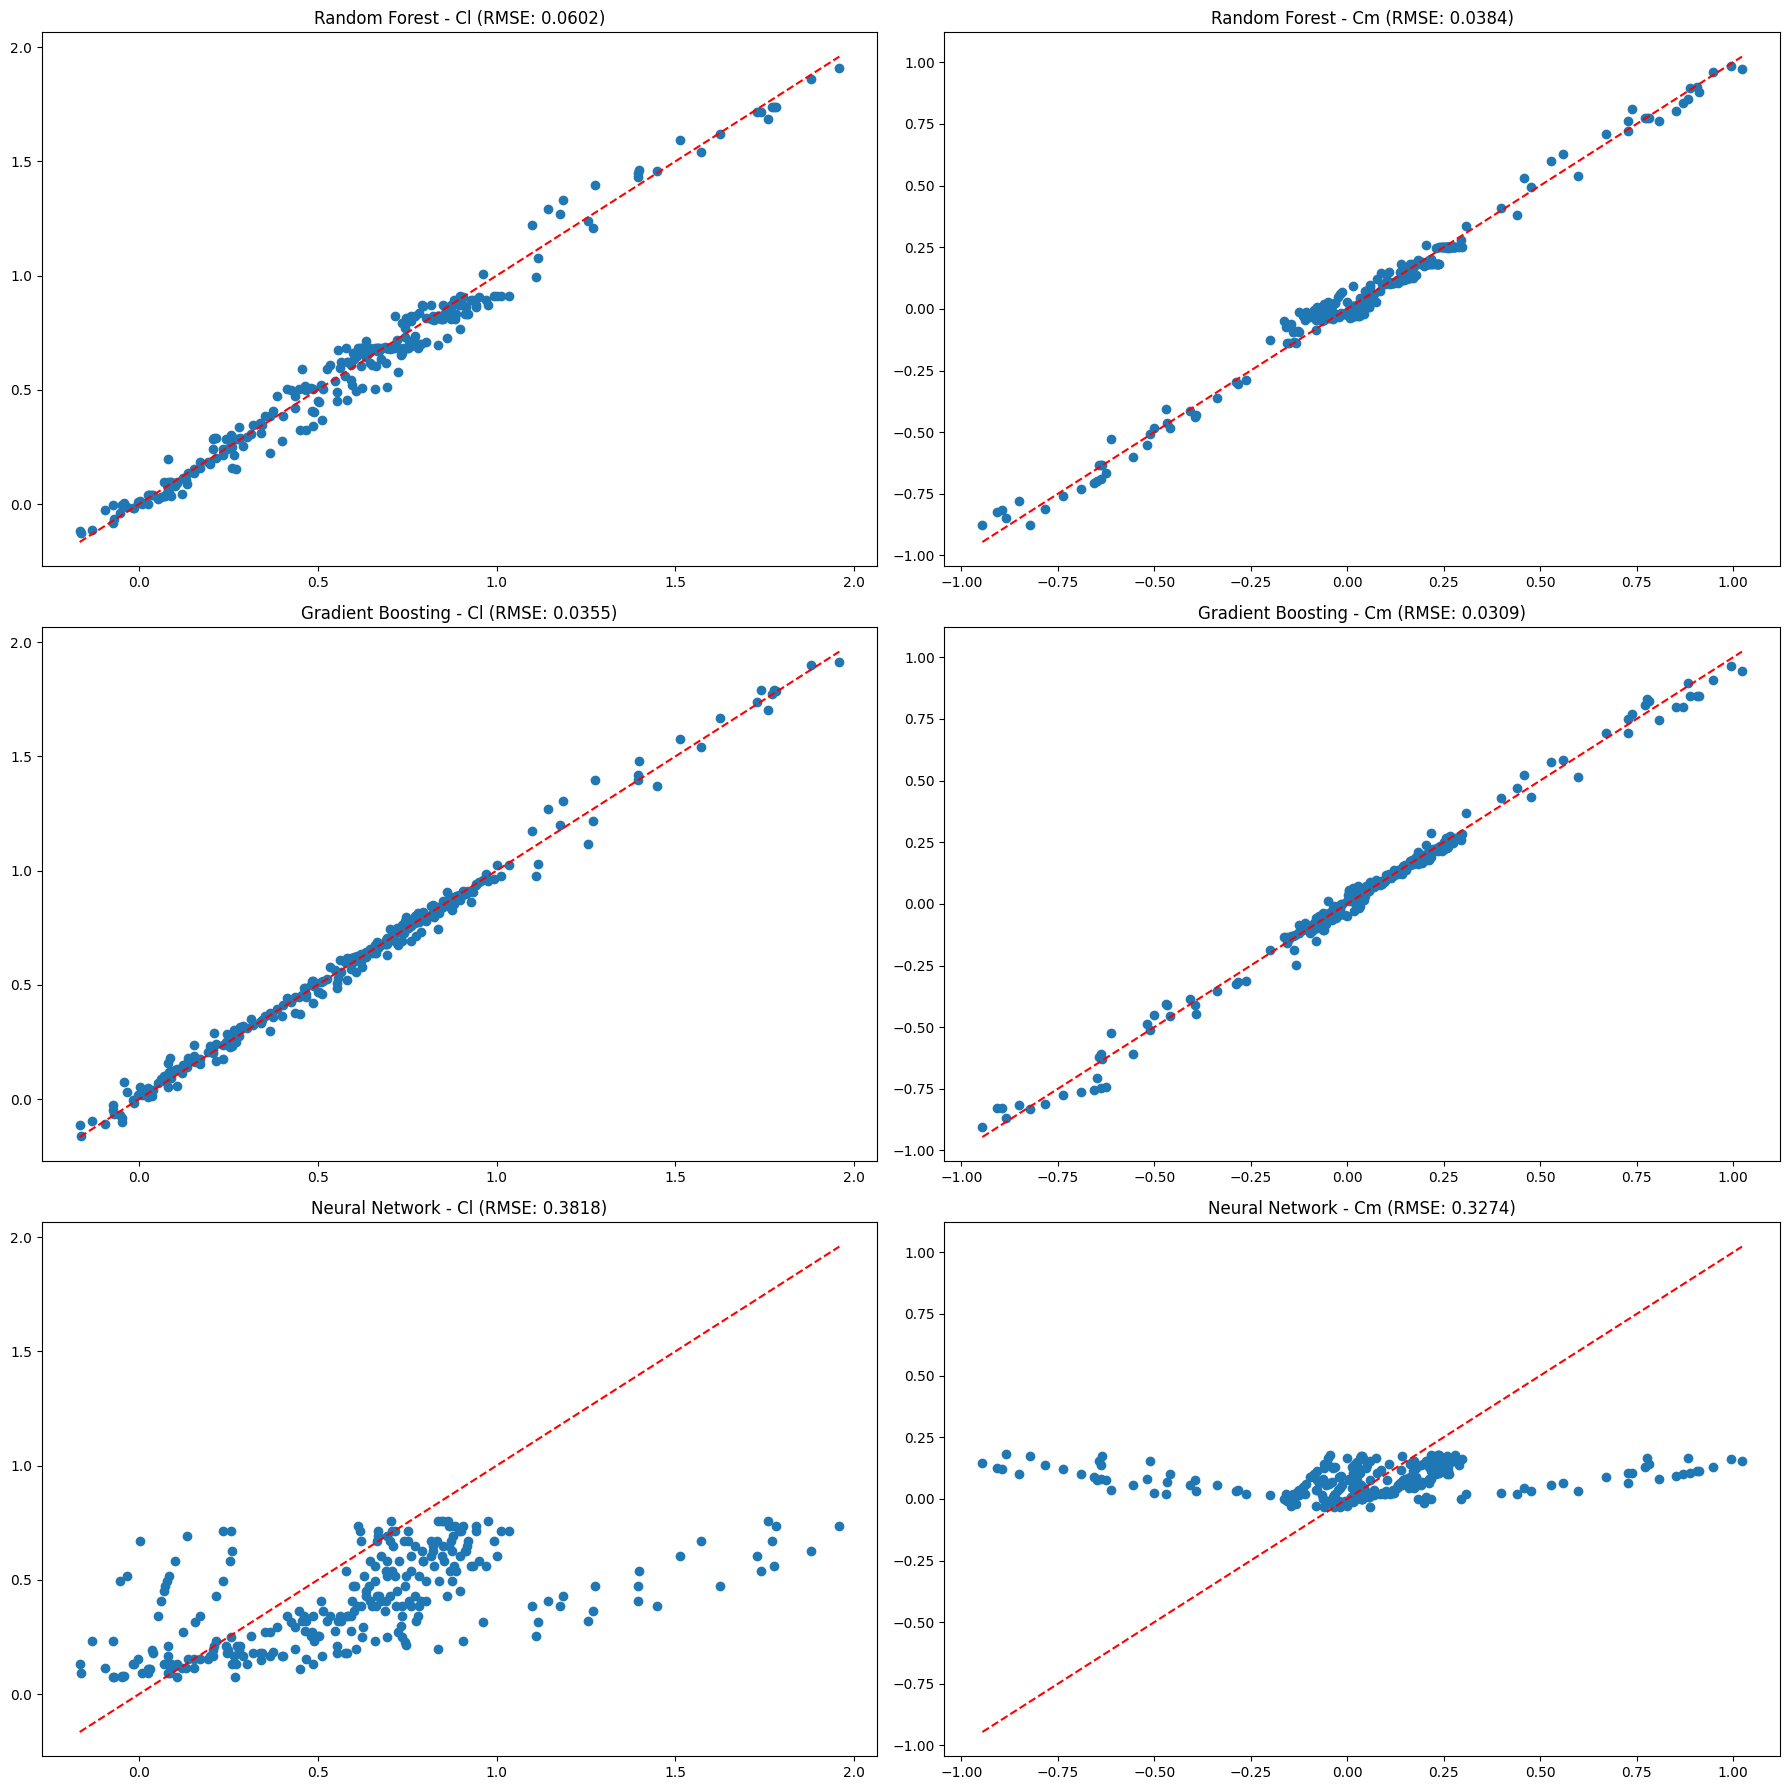

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load your CSV file
#csv_file_path = '/content/DATA_MODIFIED.csv'
csv_file_path = '/content/drive/MyDrive/DATA_MODIFIED.csv'
df = pd.read_csv(csv_file_path)

# Define the features and target variables
features = ['y_U1', 'y_U2', 'y_U3', 'y_U4', 'y_U5', 'y_U6', 'y_U7', 'y_U8',
            'y_L1', 'y_L2', 'y_L3', 'y_L4', 'y_L5', 'y_L6', 'y_L7', 'y_L8',
            'alpha', 'Mach']
targets = ['Cl', 'Cm']

# Split the data
X = df[features]
y = df[targets]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=6)
rf_model.fit(X_train, y_train)
Y_pred_rf = rf_model.predict(X_test)
rmse_rf_cl = np.sqrt(mean_squared_error(y_test['Cl'], Y_pred_rf[:, 0]))
rmse_rf_cm = np.sqrt(mean_squared_error(y_test['Cm'], Y_pred_rf[:, 1]))

# Train Gradient Boosting Regressor
xgb_model = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
xgb_model.fit(X_train, y_train['Cl'])  # Training for Cl
Y_pred_xgb_cl = xgb_model.predict(X_test)
rmse_xgb_cl = np.sqrt(mean_squared_error(y_test['Cl'], Y_pred_xgb_cl))

xgb_model.fit(X_train, y_train['Cm'])  # Training for Cm
Y_pred_xgb_cm = xgb_model.predict(X_test)
rmse_xgb_cm = np.sqrt(mean_squared_error(y_test['Cm'], Y_pred_xgb_cm))

# Neural Network for Regression
# Define Neural Network class, convert data to tensors, and train as before
# Neural Network for Regression
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(len(features), 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, len(targets))

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


# Evaluate the neural network model for 'Cl' and 'Cm'
with torch.no_grad():
    y_pred_nn = model(X_test_tensor).numpy()
rmse_nn_cl = np.sqrt(mean_squared_error(y_test['Cl'], y_pred_nn[:, 0]))
rmse_nn_cm = np.sqrt(mean_squared_error(y_test['Cm'], y_pred_nn[:, 1]))

# Visualization
fig, axs = plt.subplots(3, 2, figsize=(18, 18))

# Random Forest
axs[0, 0].scatter(y_test['Cl'], Y_pred_rf[:, 0])
axs[0, 0].plot([y_test['Cl'].min(), y_test['Cl'].max()], [y_test['Cl'].min(), y_test['Cl'].max()], 'r--')
axs[0, 0].set_title(f"Random Forest - Cl (RMSE: {rmse_rf_cl:.4f})")
axs[0, 1].scatter(y_test['Cm'], Y_pred_rf[:, 1])
axs[0, 1].plot([y_test['Cm'].min(), y_test['Cm'].max()], [y_test['Cm'].min(), y_test['Cm'].max()], 'r--')
axs[0, 1].set_title(f"Random Forest - Cm (RMSE: {rmse_rf_cm:.4f})")

# Gradient Boosting
axs[1, 0].scatter(y_test['Cl'], Y_pred_xgb_cl)
axs[1, 0].plot([y_test['Cl'].min(), y_test['Cl'].max()], [y_test['Cl'].min(), y_test['Cl'].max()], 'r--')
axs[1, 0].set_title(f"Gradient Boosting - Cl (RMSE: {rmse_xgb_cl:.4f})")
axs[1, 1].scatter(y_test['Cm'], Y_pred_xgb_cm)
axs[1, 1].plot([y_test['Cm'].min(), y_test['Cm'].max()], [y_test['Cm'].min(), y_test['Cm'].max()], 'r--')
axs[1, 1].set_title(f"Gradient Boosting - Cm (RMSE: {rmse_xgb_cm:.4f})")

# Neural Network
axs[2, 0].scatter(y_test['Cl'], y_pred_nn[:, 0])
axs[2, 0].plot([y_test['Cl'].min(), y_test['Cl'].max()], [y_test['Cl'].min(), y_test['Cl'].max()], 'r--')
axs[2, 0].set_title(f"Neural Network - Cl (RMSE: {rmse_nn_cl:.4f})")
axs[2, 1].scatter(y_test['Cm'], y_pred_nn[:, 1])
axs[2, 1].plot([y_test['Cm'].min(), y_test['Cm'].max()], [y_test['Cm'].min(), y_test['Cm'].max()], 'r--')
axs[2, 1].set_title(f"Neural Network - Cm (RMSE: {rmse_nn_cm:.4f})")

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Load the CSV file
csv_file_path = '/content/drive/MyDrive/DATA_MODIFIED.csv'
df = pd.read_csv(csv_file_path)

# Define the features and target variables
features = ['y_U1', 'y_U2', 'y_U3', 'y_U4', 'y_U5', 'y_U6', 'y_U7', 'y_U8',
            'y_L1', 'y_L2', 'y_L3', 'y_L4', 'y_L5', 'y_L6', 'y_L7', 'y_L8',
            'alpha', 'Mach']
targets = ['Cl', 'Cm']

# Split the data
X = df[features]
y = df[targets]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=6)
rf_model.fit(X_train, y_train)
Y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, Y_pred_rf))

# Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
gbr_model.fit(X_train, y_train)
Y_pred_gbr = gbr_model.predict(X_test)
rmse_gbr = np.sqrt(mean_squared_error(y_test, Y_pred_gbr))

# Neural Network for Regression
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, y_train.shape[1])

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RegressionNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Neural Network
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluation
model.eval()
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
with torch.no_grad():
    y_pred_nn = model(X_test_tensor).cpu().numpy()
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))

import matplotlib.pyplot as plt

# Assuming 'feature_importance' is a dictionary with keys 'Cl' and 'Cm'
# And 'features' is your list of feature names

fig, axs = plt.subplots(2, 1, figsize=(12, 12))  # Two subplots, one for each target variable

for i, target_variable in enumerate(target_variables):
    importance = feature_importance[target_variable]

    axs[i].barh(features, importance, color='skyblue')
    axs[i].set_xlabel('Feature Importance')
    axs[i].set_title(f'Feature Importance for {target_variable}')

    # Adding text annotations for importance values
    for j, v in enumerate(importance):
        axs[i].text(v, j, f'{v:.2f}', va='center', fontsize=10, color='black', fontweight='bold')

# Setting labels for the y-axis
axs[0].set_ylabel('Features for Cl')
axs[1].set_ylabel('Features for Cm')

plt.tight_layout()
plt.show()

ValueError: ignored

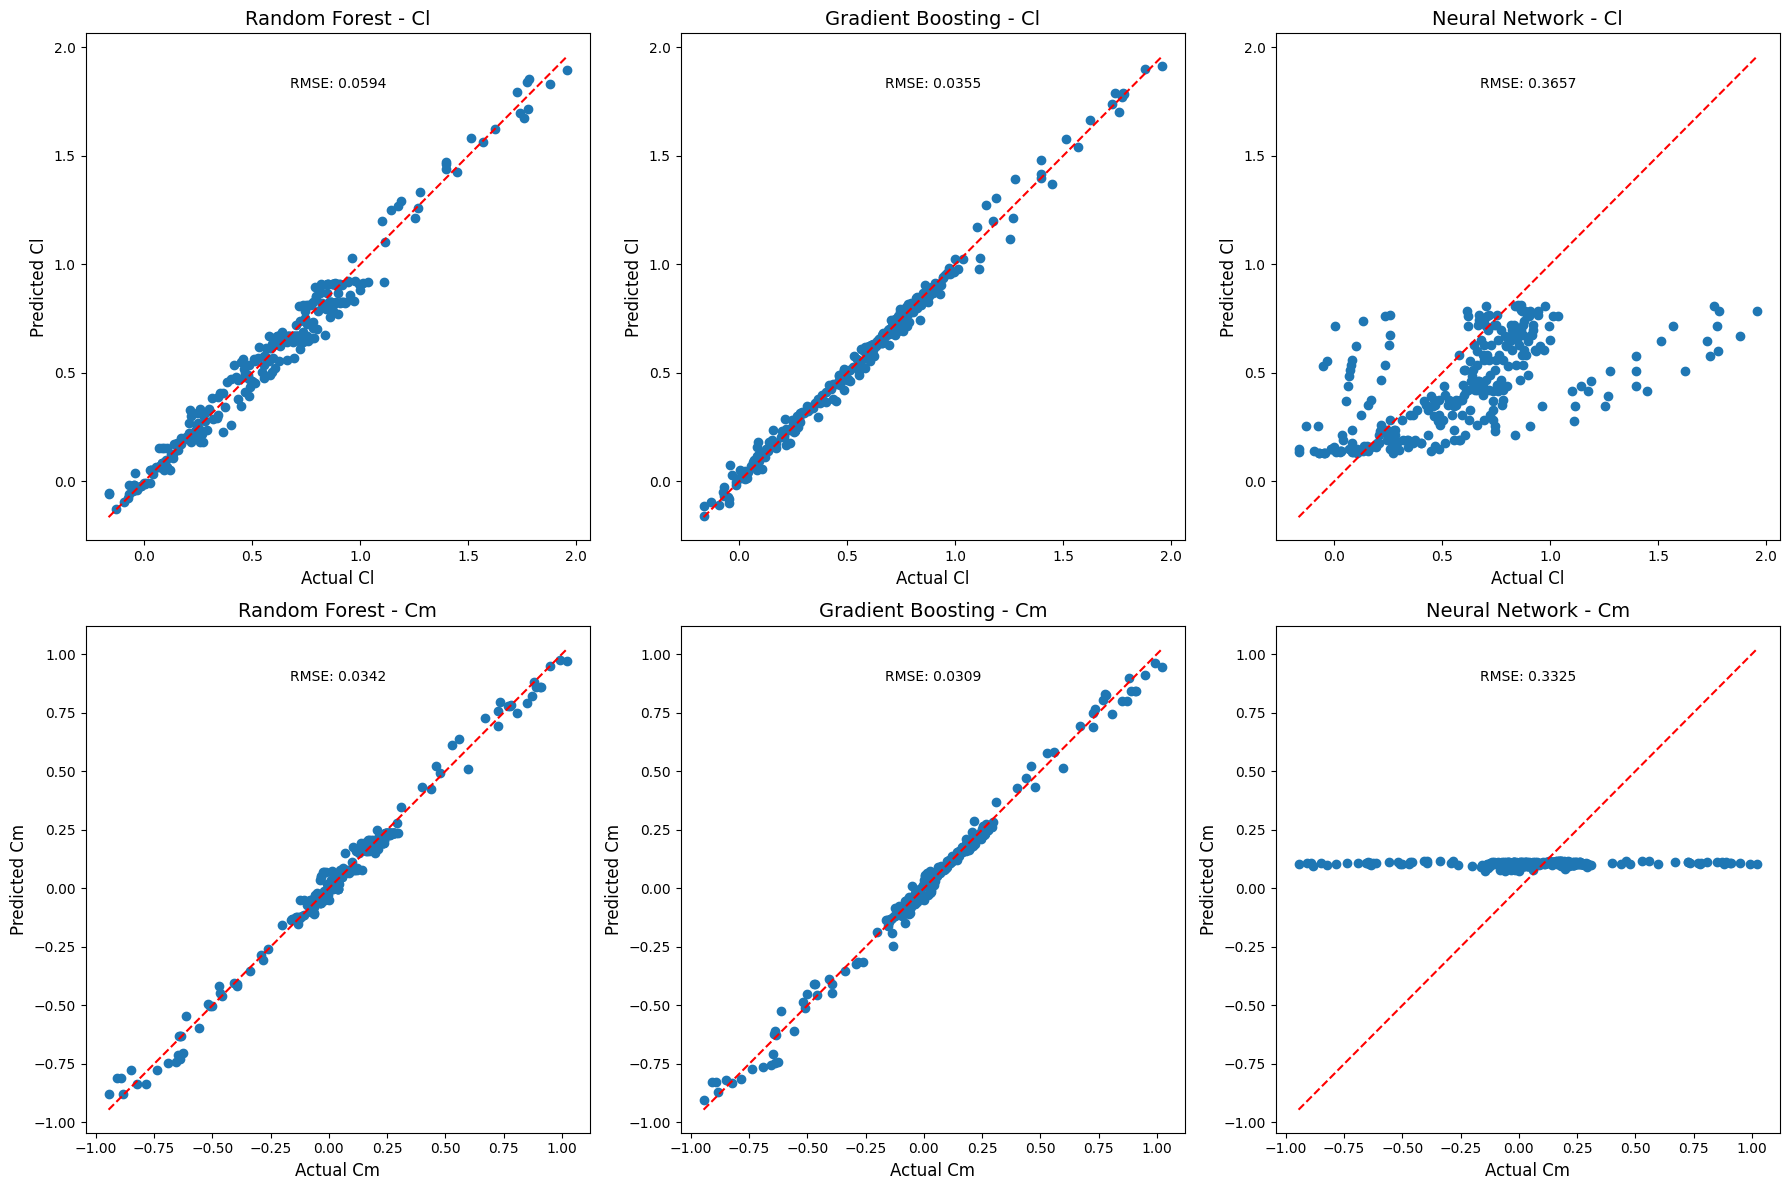

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Load the CSV file
csv_file_path = '/content/drive/MyDrive/DATA_MODIFIED.csv'
df = pd.read_csv(csv_file_path)

# Define the features and target variables
features = ['y_U1', 'y_U2', 'y_U3', 'y_U4', 'y_U5', 'y_U6', 'y_U7', 'y_U8',
            'y_L1', 'y_L2', 'y_L3', 'y_L4', 'y_L5', 'y_L6', 'y_L7', 'y_L8',
            'alpha', 'Mach']
targets = ['Cl', 'Cm']

# Split the data
X = df[features]
y_cl = df['Cl']
y_cm = df['Cm']
X_train, X_test, y_train_cl, y_test_cl = train_test_split(X, y_cl, test_size=0.2, random_state=42)
_, _, y_train_cm, y_test_cm = train_test_split(X, y_cm, test_size=0.2, random_state=42)

# Train Random Forest Regressor for Cl and Cm
rf_model_cl = RandomForestRegressor(n_estimators=100, max_depth=6)
rf_model_cl.fit(X_train, y_train_cl)
Y_pred_rf_cl = rf_model_cl.predict(X_test)
rmse_rf_cl = np.sqrt(mean_squared_error(y_test_cl, Y_pred_rf_cl))

rf_model_cm = RandomForestRegressor(n_estimators=100, max_depth=6)
rf_model_cm.fit(X_train, y_train_cm)
Y_pred_rf_cm = rf_model_cm.predict(X_test)
rmse_rf_cm = np.sqrt(mean_squared_error(y_test_cm, Y_pred_rf_cm))

# Train Gradient Boosting Regressor for Cl and Cm
gbr_model_cl = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
gbr_model_cl.fit(X_train, y_train_cl)
Y_pred_gbr_cl = gbr_model_cl.predict(X_test)
rmse_gbr_cl = np.sqrt(mean_squared_error(y_test_cl, Y_pred_gbr_cl))

gbr_model_cm = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
gbr_model_cm.fit(X_train, y_train_cm)
Y_pred_gbr_cm = gbr_model_cm.predict(X_test)
rmse_gbr_cm = np.sqrt(mean_squared_error(y_test_cm, Y_pred_gbr_cm))

# Neural Network for Regression
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(len(features), 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)  # Output size is 2 for 'Cl' and 'Cm'

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(pd.concat([y_train_cl, y_train_cm], axis=1).values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(pd.concat([y_test_cl, y_test_cm], axis=1).values, dtype=torch.float32)


# Initialize model, loss function, and optimizer
model = RegressionNN()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.MSELoss()

# Training the Neural Network
num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluation
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test_tensor).numpy()
rmse_nn_cl = np.sqrt(mean_squared_error(y_test_cl, y_pred_nn[:, 0]))
rmse_nn_cm = np.sqrt(mean_squared_error(y_test_cm, y_pred_nn[:, 1]))

# Visualization of results
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
model_names = ['Random Forest', 'Gradient Boosting', 'Neural Network']
predictions_cl = [Y_pred_rf_cl, Y_pred_gbr_cl, y_pred_nn[:, 0]]
predictions_cm = [Y_pred_rf_cm, Y_pred_gbr_cm, y_pred_nn[:, 1]]
rmses_cl = [rmse_rf_cl, rmse_gbr_cl, rmse_nn_cl]
rmses_cm = [rmse_rf_cm, rmse_gbr_cm, rmse_nn_cm]

for i in range(len(model_names)):
    # Cl
    axs[0, i].scatter(y_test_cl, predictions_cl[i])
    axs[0, i].plot([y_test_cl.min(), y_test_cl.max()], [y_test_cl.min(), y_test_cl.max()], 'r--')
    axs[0, i].set_title(f"{model_names[i]} - Cl", fontsize=14)
    axs[0, i].set_xlabel('Actual Cl', fontsize=12)
    axs[0, i].set_ylabel('Predicted Cl', fontsize=12)
    axs[0, i].text(0.5, 0.9, f"RMSE: {rmses_cl[i]:.4f}", fontsize=10, ha='center', va='center', transform=axs[0, i].transAxes)

    # Cm
    axs[1, i].scatter(y_test_cm, predictions_cm[i])
    axs[1, i].plot([y_test_cm.min(), y_test_cm.max()], [y_test_cm.min(), y_test_cm.max()], 'r--')
    axs[1, i].set_title(f"{model_names[i]} - Cm", fontsize=14)
    axs[1, i].set_xlabel('Actual Cm', fontsize=12)
    axs[1, i].set_ylabel('Predicted Cm', fontsize=12)
    axs[1, i].text(0.5, 0.9, f"RMSE: {rmses_cm[i]:.4f}", fontsize=10, ha='center', va='center', transform=axs[1, i].transAxes)

plt.tight_layout()
plt.show()

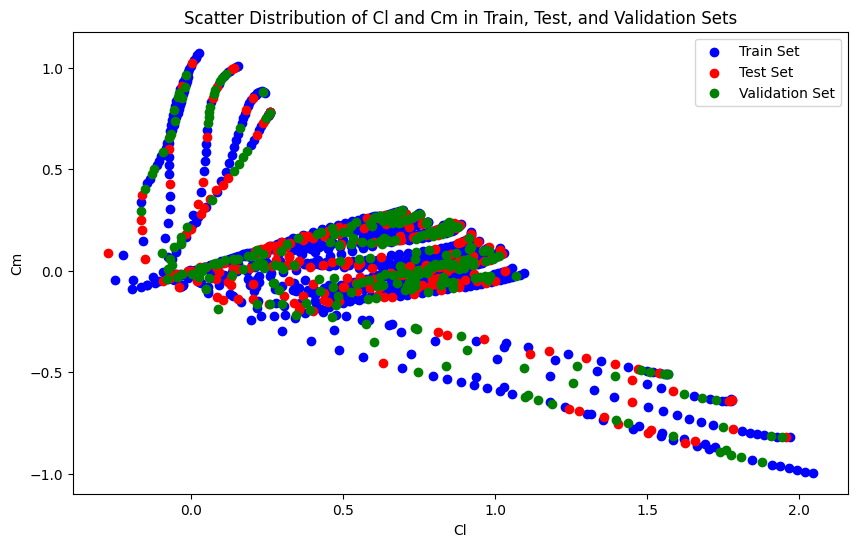

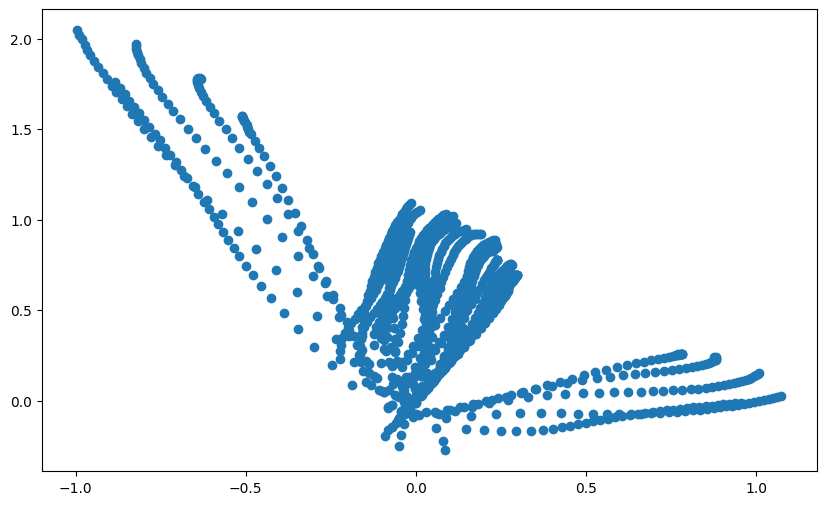

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load your dataset
csv_file_path = '/content/drive/MyDrive/DATA_MODIFIED.csv'
df = pd.read_csv(csv_file_path)

# Assuming 'Cl' and 'Cm' are your target variables
X = df.drop(['Cl', 'Cm'], axis=1)  # Features
y = df[['Cl', 'Cm']]  # Targets

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Plotting
plt.figure(figsize=(10, 6))

# Train set in blue
plt.scatter(y_train['Cl'], y_train['Cm'], color='blue', label='Train Set')

# Test set in red
plt.scatter(y_test['Cl'], y_test['Cm'], color='red', label='Test Set')

# Validation set in green
plt.scatter(y_val['Cl'], y_val['Cm'], color='green', label='Validation Set')

plt.xlabel('Cl')
plt.ylabel('Cm')
plt.title('Scatter Distribution of Cl and Cm in Train, Test, and Validation Sets')
plt.legend()
plt.show()



plt.figure(figsize=(10, 6))

plt.scatter(y['Cm'], y['Cl'], )
plt.show()




In [ ]:
import pandas as pd

# Assuming df is your DataFrame
# Example DataFrame loading
df = pd.read_csv('/content/drive/MyDrive/DATA_MODIFIED.csv')

# Create a unique identifier for each airfoil based on coordinates
# Adjust this according to how your coordinates are structured
df['airfoil_id'] = df.apply(lambda row: f"{row['y_U1']}-{row['y_U2']}-...-{row['y_L8']}", axis=1)

# Group by this identifier and find the max Cl and Cm
max_values = df.groupby('airfoil_id')['Cl', 'Cm'].max().reset_index()
min_values = df.groupby('airfoil_id')['Cl', 'Cm'].min().reset_index()

print(max_values)
print(min_values)


# Assuming max_values and min_values are your DataFrames
# Simplify airfoil IDs if necessary (optional)
airfoil_names = [f'Airfoil{i+1}' for i in range(len(max_values))]
max_values['airfoil_id'] = airfoil_names
min_values['airfoil_id'] = airfoil_names

# Merge max and min values into a single DataFrame
combined_values = pd.merge(max_values, min_values, on='airfoil_id', suffixes=('_max', '_min'))

# Convert to LaTeX format
combined_latex = combined_values.to_latex(index=False,
                                         header=["Airfoil ID", "$C_l^{max}$", "$C_m^{max}$", "$C_l^{min}$", "$C_m^{min}$"])

# Print LaTeX table
print("Combined Maximum and Minimum Values Table:")
print(combined_latex)

                  airfoil_id        Cl        Cm
0  0.0401-0.0537-...--0.0017  2.045635 -0.070726
1  0.0485-0.0584-...--0.0164  0.978726  0.278827
2  0.0538-0.0664-...--0.0016  0.260455  1.074361
3  0.0587-0.0746-...--0.0093  1.054212  0.239515
4  0.0665-0.0756-...--0.0138  1.030885  0.281320
5   0.069-0.0909-...--0.0024  1.093571  0.234184
6    0.0691-0.085-...--0.016  0.979667  0.297061
7  0.0697-0.0826-...--0.0158  0.975965  0.266826
                  airfoil_id        Cl        Cm
0  0.0401-0.0537-...--0.0017 -0.042260 -0.995812
1  0.0485-0.0584-...--0.0164 -0.273977 -0.090342
2  0.0538-0.0664-...--0.0016 -0.166237  0.055388
3  0.0587-0.0746-...--0.0093  0.019316 -0.164258
4  0.0665-0.0756-...--0.0138 -0.080589 -0.105795
5   0.069-0.0909-...--0.0024  0.185666 -0.224055
6    0.0691-0.085-...--0.016 -0.091901 -0.124113
7  0.0697-0.0826-...--0.0158 -0.076543 -0.099509
Combined Maximum and Minimum Values Table:
\begin{tabular}{lrrrr}
\toprule
Airfoil ID & \$C\_l\textasciicircum \{max\}

<ipython-input-91-d76cb5d68ea2>:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  max_values = df.groupby('airfoil_id')['Cl', 'Cm'].max().reset_index()
<ipython-input-91-d76cb5d68ea2>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  min_values = df.groupby('airfoil_id')['Cl', 'Cm'].min().reset_index()
<ipython-input-91-d76cb5d68ea2>:29: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  combined_latex = combined_values.to_latex(index=False,


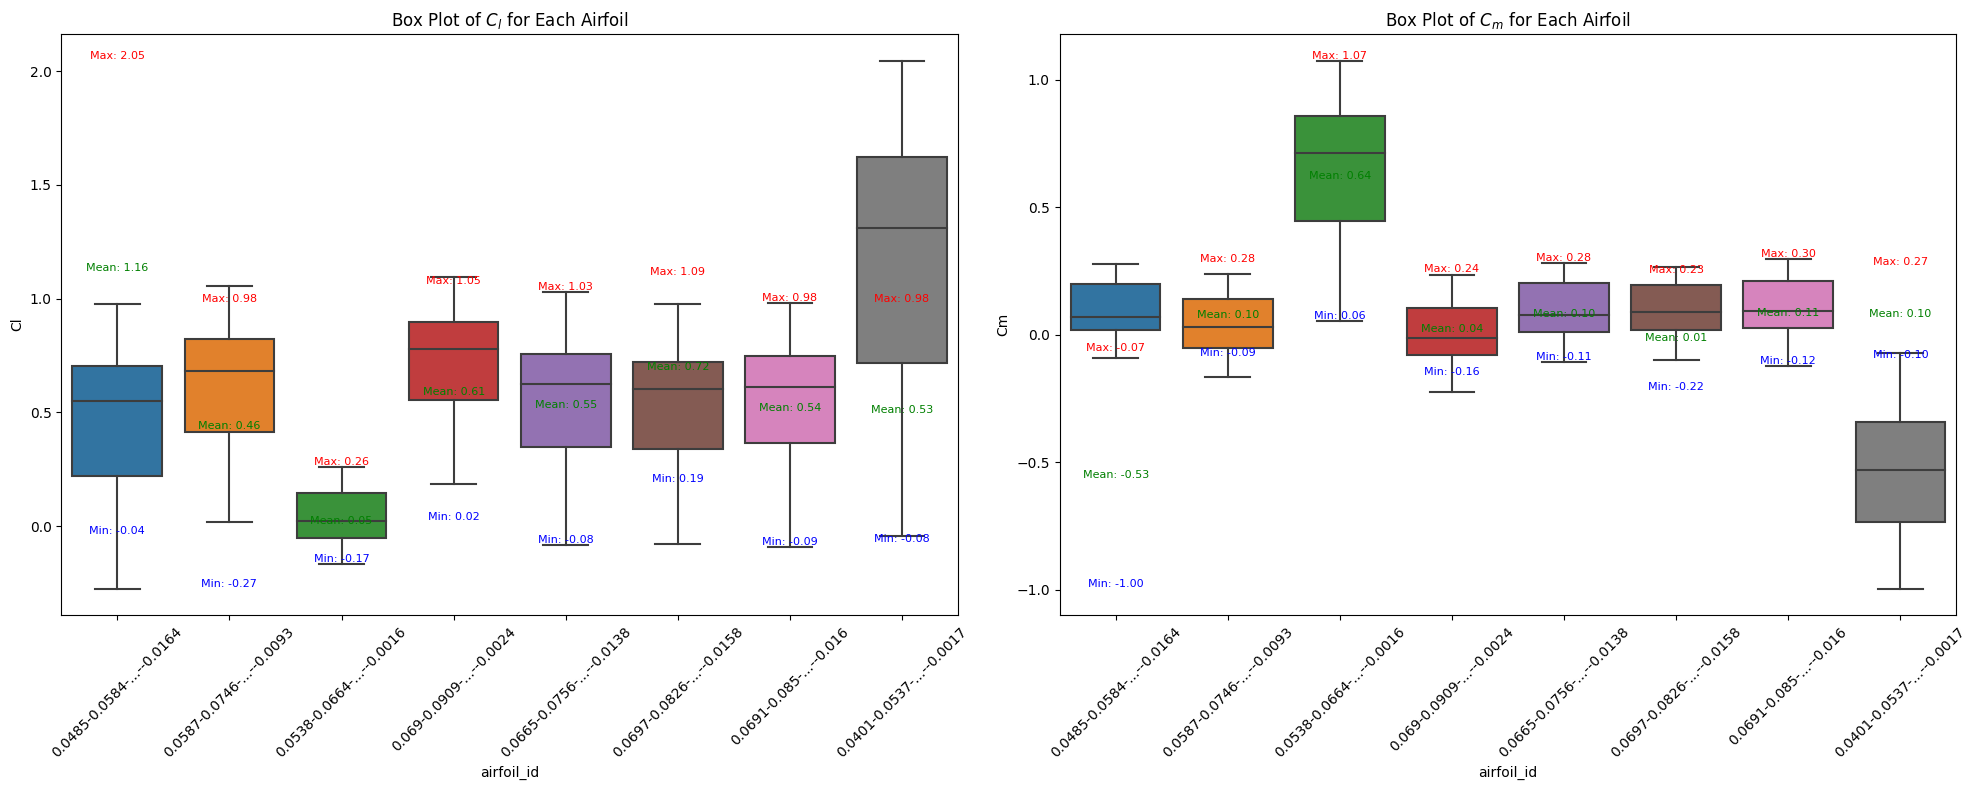

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data
csv_file_path = '/content/drive/MyDrive/DATA_MODIFIED.csv'
df = pd.read_csv(csv_file_path)

df['airfoil_id'] = df.apply(lambda row: f"{row['y_U1']}-{row['y_U2']}-...-{row['y_L8']}", axis=1)

# Create the figure and the two subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Boxplot for Cl
sns.boxplot(x='airfoil_id', y='Cl', data=df, ax=axs[0])
axs[0].set_title('Box Plot of $C_l$ for Each Airfoil')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)

# Boxplot for Cm
sns.boxplot(x='airfoil_id', y='Cm', data=df, ax=axs[1])
axs[1].set_title('Box Plot of $C_m$ for Each Airfoil')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)

# Annotate each boxplot with min, max, and mean
for i, feature in enumerate(['Cl', 'Cm']):
    grouped = df.groupby('airfoil_id')[feature].agg(['min', 'mean', 'max']).reset_index()
    for j in range(len(grouped)):
        # Position for the annotations
        y_min, y_mean, y_max = grouped.loc[j, ['min', 'mean', 'max']]
        x = j

        axs[i].text(x, y_min, f'Min: {y_min:.2f}', ha='center', va='bottom', fontsize=8, color='blue')
        axs[i].text(x, y_mean, f'Mean: {y_mean:.2f}', ha='center', va='top', fontsize=8, color='green')
        axs[i].text(x, y_max, f'Max: {y_max:.2f}', ha='center', va='bottom', fontsize=8, color='red')

plt.tight_layout()
plt.show()



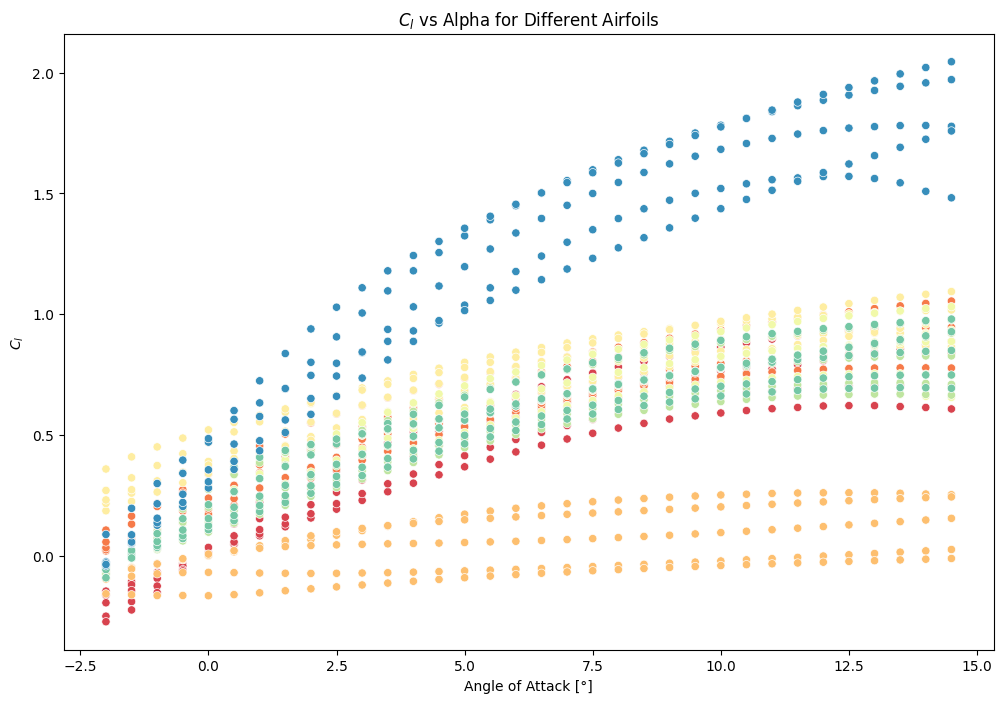

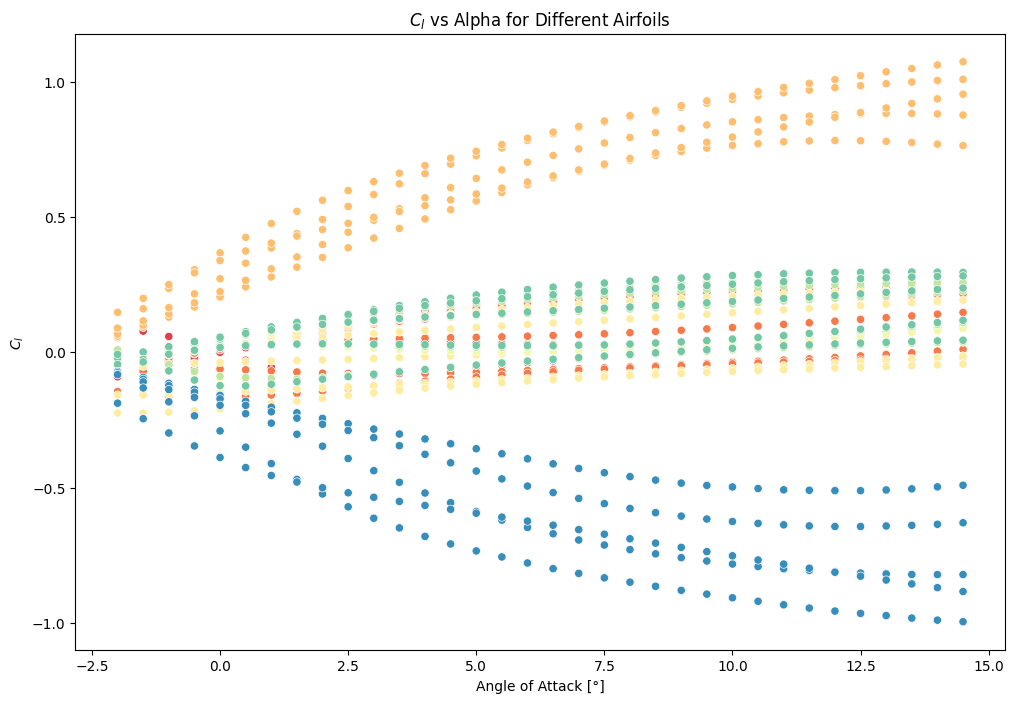

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data
csv_file_path = '/content/drive/MyDrive/DATA_MODIFIED.csv'
df = pd.read_csv(csv_file_path)

# Create a unique identifier for each airfoil based on coordinates
coordinate_columns = [f'y_U{i}' for i in range(1, 9)] + [f'y_L{i}' for i in range(1, 9)]
df['airfoil_id'] = df.apply(lambda row: '-'.join(row[coordinate_columns].astype(str)), axis=1)

# Plot Cl vs Alpha with different colors for each airfoil
plt.figure(figsize=(12, 8))
sns.scatterplot(x='alpha', y='Cl', hue='airfoil_id', data=df, palette='Spectral', legend=False)
plt.title('$C_l$ vs Alpha for Different Airfoils')
plt.xlabel('Angle of Attack [°]')
plt.ylabel('$C_l$')
plt.show()

# Plot Cl vs Alpha with different colors for each airfoil
plt.figure(figsize=(12, 8))
sns.scatterplot(x='alpha', y='Cm', hue='airfoil_id', data=df, palette='Spectral', legend=False)
plt.title('$C_l$ vs Alpha for Different Airfoils')
plt.xlabel('Angle of Attack [°]')
plt.ylabel('$C_l$')
plt.show()


<ipython-input-94-14cc1be0b37d>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stats_df = df.groupby('airfoil_id')['Cl', 'Cm'].agg(['min', 'max']).reset_index()


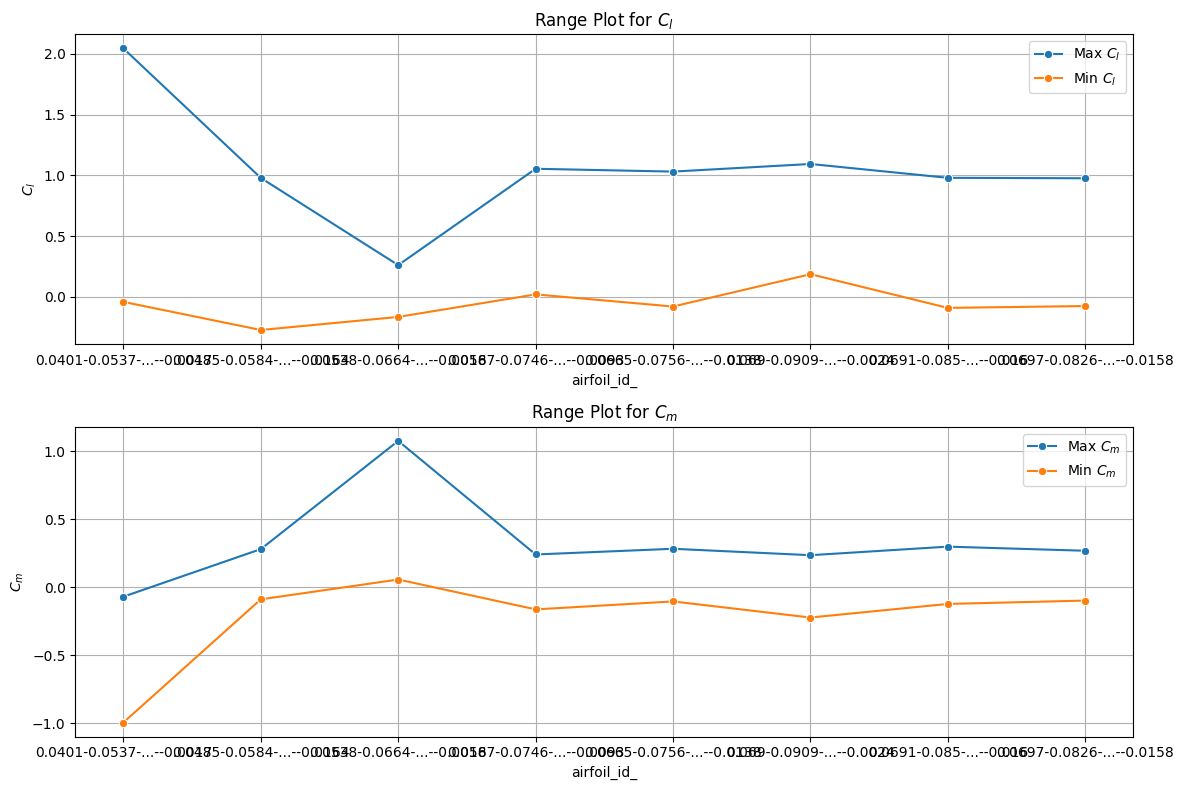

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Load your data
csv_file_path = '/content/drive/MyDrive/DATA_MODIFIED.csv'
df = pd.read_csv(csv_file_path)

df['airfoil_id'] = df.apply(lambda row: f"{row['y_U1']}-{row['y_U2']}-...-{row['y_L8']}", axis=1)

# Calculate min and max for Cl and Cm for each airfoil
stats_df = df.groupby('airfoil_id')['Cl', 'Cm'].agg(['min', 'max']).reset_index()

# Flatten the column names
stats_df.columns = ['_'.join(col).strip() for col in stats_df.columns.values]

# Create the figure with two subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# High-Low plot for Cl using Seaborn
sns.lineplot(x='airfoil_id_', y='Cl_max', data=stats_df, ax=ax[0], marker='o', label='Max $C_l$')
sns.lineplot(x='airfoil_id_', y='Cl_min', data=stats_df, ax=ax[0], marker='o', label='Min $C_l$')
ax[0].set_title('Range Plot for $C_l$')
ax[0].set_ylabel('$C_l$')
ax[0].legend()
ax[0].grid()
# High-Low plot for Cm using Seaborn
sns.lineplot(x='airfoil_id_', y='Cm_max', data=stats_df, ax=ax[1], marker='o', label='Max $C_m$')
sns.lineplot(x='airfoil_id_', y='Cm_min', data=stats_df, ax=ax[1], marker='o', label='Min $C_m$')
ax[1].set_title('Range Plot for $C_m$')
ax[1].set_ylabel('$C_m$')
ax[1].legend()
ax[1].grid()
plt.tight_layout()
plt.show()


<ipython-input-19-7d914b0bf130>:15: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stats_df = df.groupby('airfoil_id')['Cl', 'Cm'].agg(['min', 'max']).reset_index()


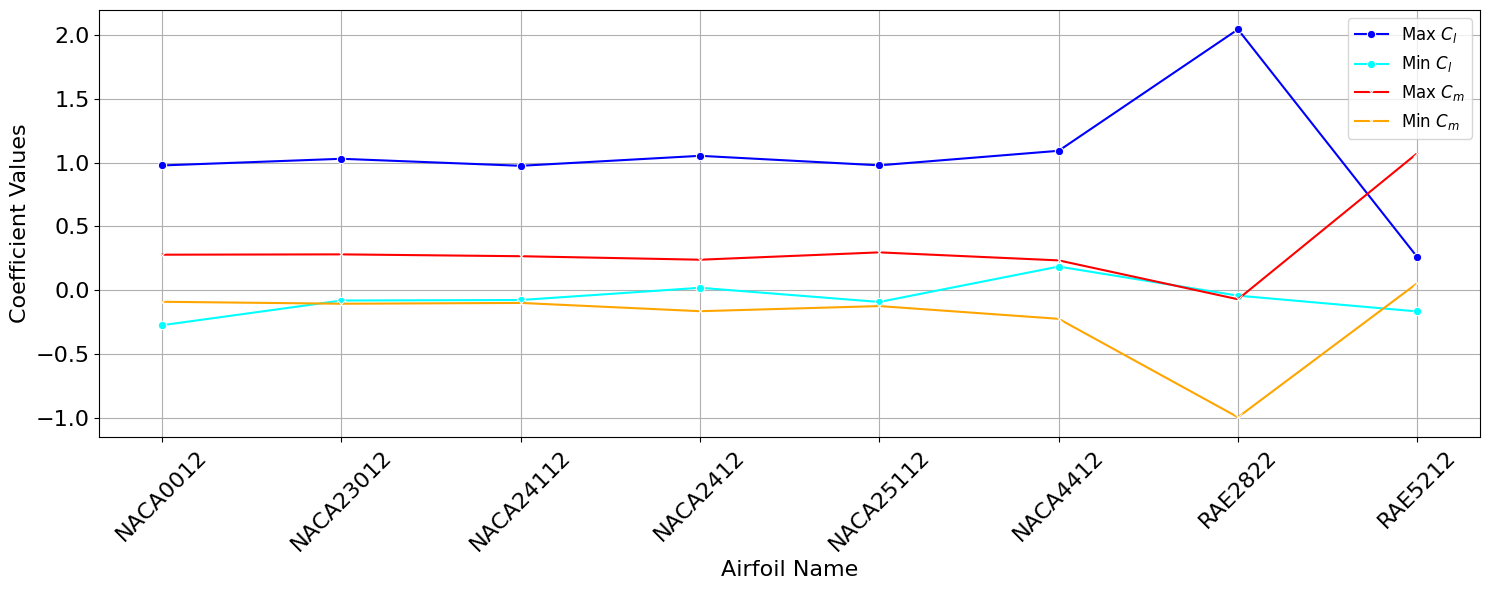

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data
csv_file_path = '/content/drive/MyDrive/DATA_MODIFIED.csv'
df = pd.read_csv(csv_file_path)

# Create 'airfoil_id' column
#df['airfoil_id'] = df.apply(lambda row: f"{row['y_U1']}-{row['y_U2']}-...-{row['y_L8']}", axis=1)
#airfoil_id=['NACA0012','NACA2412','RAE5212','NACA4412','NACA23012','NACA24112','NACA25112','RAE2822']
df['airfoil_id'] = df['Airfoil ID']

# Calculate min and max for Cl and Cm for each airfoil
stats_df = df.groupby('airfoil_id')['Cl', 'Cm'].agg(['min', 'max']).reset_index()

# Flatten the column names
stats_df.columns = ['_'.join(col).strip() for col in stats_df.columns.values]

# Create the figure
fig, ax = plt.subplots(figsize=(15, 6))  # Adjust size as needed

# Define font sizes
title_fontsize = 16
label_fontsize = 16
tick_fontsize = 16

# Line plots for Cl and Cm
sns.lineplot(x='airfoil_id_', y='Cl_max', data=stats_df, ax=ax, marker='o', label='Max $C_l$', color='blue')
sns.lineplot(x='airfoil_id_', y='Cl_min', data=stats_df, ax=ax, marker='o', label='Min $C_l$', color='cyan')
sns.lineplot(x='airfoil_id_', y='Cm_max', data=stats_df, ax=ax, marker='x', label='Max $C_m$', color='red')
sns.lineplot(x='airfoil_id_', y='Cm_min', data=stats_df, ax=ax, marker='x', label='Min $C_m$', color='orange')

# Setting titles and labels
#ax.set_title('Range Plots for $C_l$ and $C_m$', fontsize=title_fontsize)
ax.set_xlabel('Airfoil Name', fontsize=label_fontsize)
ax.set_ylabel('Coefficient Values', fontsize=label_fontsize)
ax.tick_params(axis='x', rotation=45, labelsize=tick_fontsize)  # Rotate x-axis labels
ax.tick_params(axis='y', labelsize=tick_fontsize)  # Set y-axis tick font size
ax.legend(fontsize=12)  # Set legend font size
ax.grid()

plt.tight_layout()
plt.show()


# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Define the airfoil IDs list
# airfoil_ids = ['NACA0012', 'NACA2412', 'RAE5212', 'NACA4412', 'NACA23012', 'NACA24112', 'NACA25112', 'RAE2822']

# # Create 'airfoil_id' column using the predefined list
# df['airfoil_id'] = df.apply(lambda row: f"{row['y_U1']}-{row['y_U2']}-...-{row['y_L8']}", axis=1)

# # Calculate min and max for Cl and Cm for each airfoil
# stats_df = df.groupby('airfoil_id')['Cl', 'Cm'].agg(['min', 'max']).reset_index()

# # Flatten the column names
# stats_df.columns = ['_'.join(col).strip() for col in stats_df.columns.values]

# # Create the figure
# fig, ax = plt.subplots(figsize=(15, 6))  # Adjust size as needed

# # Define font sizes
# title_fontsize = 14
# label_fontsize = 12
# tick_fontsize = 10

# # Line plots for Cl and Cm
# sns.lineplot(x='airfoil_id_', y='Cl_max', data=stats_df, ax=ax, marker='o', label='Max $C_l$', color='blue')
# sns.lineplot(x='airfoil_id_', y='Cl_min', data=stats_df, ax=ax, marker='o', label='Min $C_l$', color='cyan')
# sns.lineplot(x='airfoil_id_', y='Cm_max', data=stats_df, ax=ax, marker='x', label='Max $C_m$', color='red')
# sns.lineplot(x='airfoil_id_', y='Cm_min', data=stats_df, ax=ax, marker='x', label='Min $C_m$', color='orange')

# # Setting titles and labels
# ax.set_title('Range Plots for $C_l$ and $C_m$', fontsize=title_fontsize)
# ax.set_xlabel('Airfoil ID', fontsize=label_fontsize)
# ax.set_ylabel('Coefficient Values', fontsize=label_fontsize)
# ax.set_xticks(range(len(airfoil_ids)))  # Set x-axis ticks to match airfoil IDs
# ax.set_xticklabels(airfoil_ids, rotation=45, fontsize=tick_fontsize)  # Set x-axis labels
# ax.legend()
# ax.grid()

# plt.tight_layout()
# plt.show()


<ipython-input-96-f2813796c233>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stats_df = df.groupby('airfoil_id')['Cl', 'Cm'].agg(['min', 'max']).reset_index()


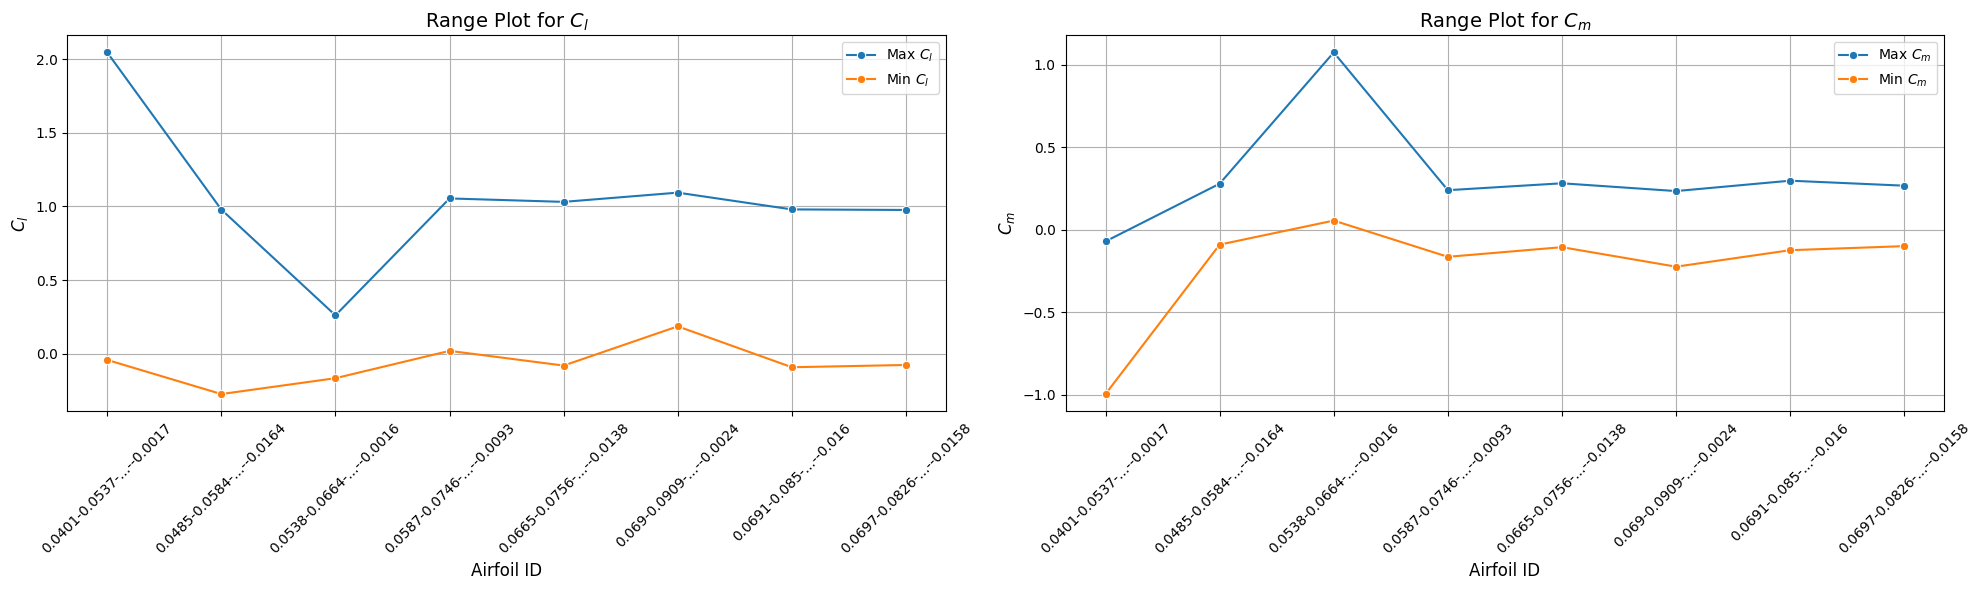

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data
csv_file_path = '/content/drive/MyDrive/DATA_MODIFIED.csv'
df = pd.read_csv(csv_file_path)

# Create 'airfoil_id' column
df['airfoil_id'] = df.apply(lambda row: f"{row['y_U1']}-{row['y_U2']}-...-{row['y_L8']}", axis=1)

# Calculate min and max for Cl and Cm for each airfoil
stats_df = df.groupby('airfoil_id')['Cl', 'Cm'].agg(['min', 'max']).reset_index()

# Flatten the column names
stats_df.columns = ['_'.join(col).strip() for col in stats_df.columns.values]

# Create the figure with one row and two columns
fig, ax = plt.subplots(1, 2, figsize=(20, 6))  # Adjust size as needed

# Define font sizes
title_fontsize = 14
label_fontsize = 12
tick_fontsize = 10

# High-Low plot for Cl
sns.lineplot(x='airfoil_id_', y='Cl_max', data=stats_df, ax=ax[0], marker='o', label='Max $C_l$')
sns.lineplot(x='airfoil_id_', y='Cl_min', data=stats_df, ax=ax[0], marker='o', label='Min $C_l$')
ax[0].set_title('Range Plot for $C_l$', fontsize=title_fontsize)
ax[0].set_xlabel('Airfoil ID', fontsize=label_fontsize)
ax[0].set_ylabel('$C_l$', fontsize=label_fontsize)
ax[0].tick_params(axis='x', rotation=45, labelsize=tick_fontsize)  # Rotate x-axis labels
ax[0].legend()
ax[0].grid()

# High-Low plot for Cm
sns.lineplot(x='airfoil_id_', y='Cm_max', data=stats_df, ax=ax[1], marker='o', label='Max $C_m$')
sns.lineplot(x='airfoil_id_', y='Cm_min', data=stats_df, ax=ax[1], marker='o', label='Min $C_m$')
ax[1].set_title('Range Plot for $C_m$', fontsize=title_fontsize)
ax[1].set_xlabel('Airfoil ID', fontsize=label_fontsize)
ax[1].set_ylabel('$C_m$', fontsize=label_fontsize)
ax[1].tick_params(axis='x', rotation=45, labelsize=tick_fontsize)  # Rotate x-axis labels
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()


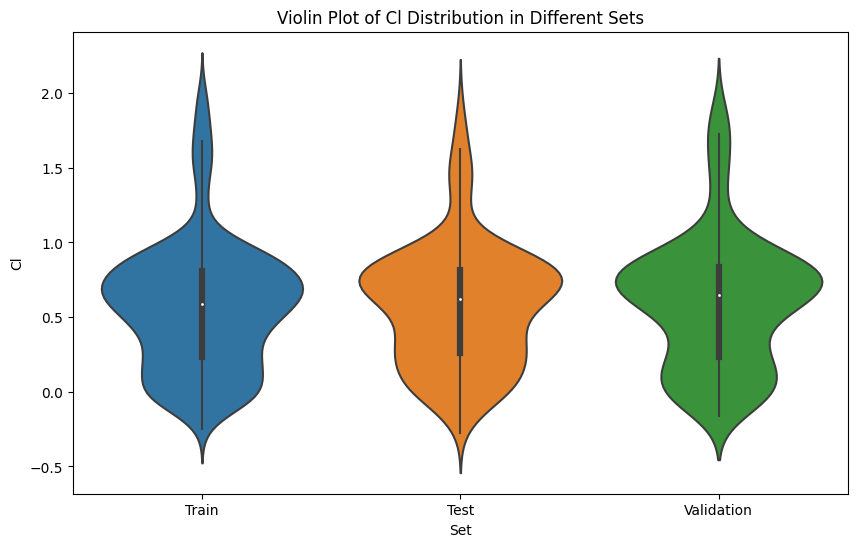

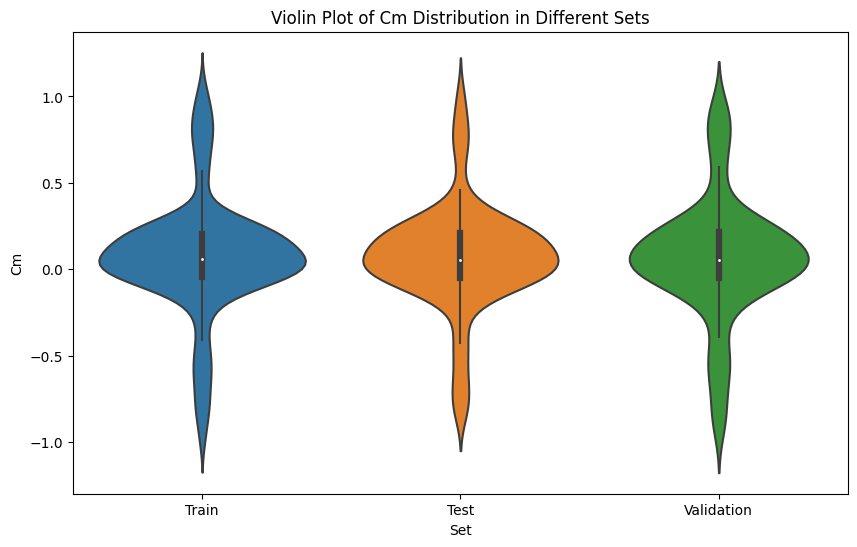

In [ ]:
import seaborn as sns

# Combining data for plotting
combined_data = pd.concat([y_train.assign(Set='Train'),
                           y_test.assign(Set='Test'),
                           y_val.assign(Set='Validation')])

plt.figure(figsize=(10, 6))

sns.violinplot(x='Set', y='Cl', data=combined_data)
plt.title('Violin Plot of Cl Distribution in Different Sets')
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(x='Set', y='Cm', data=combined_data)
plt.title('Violin Plot of Cm Distribution in Different Sets')
plt.show()


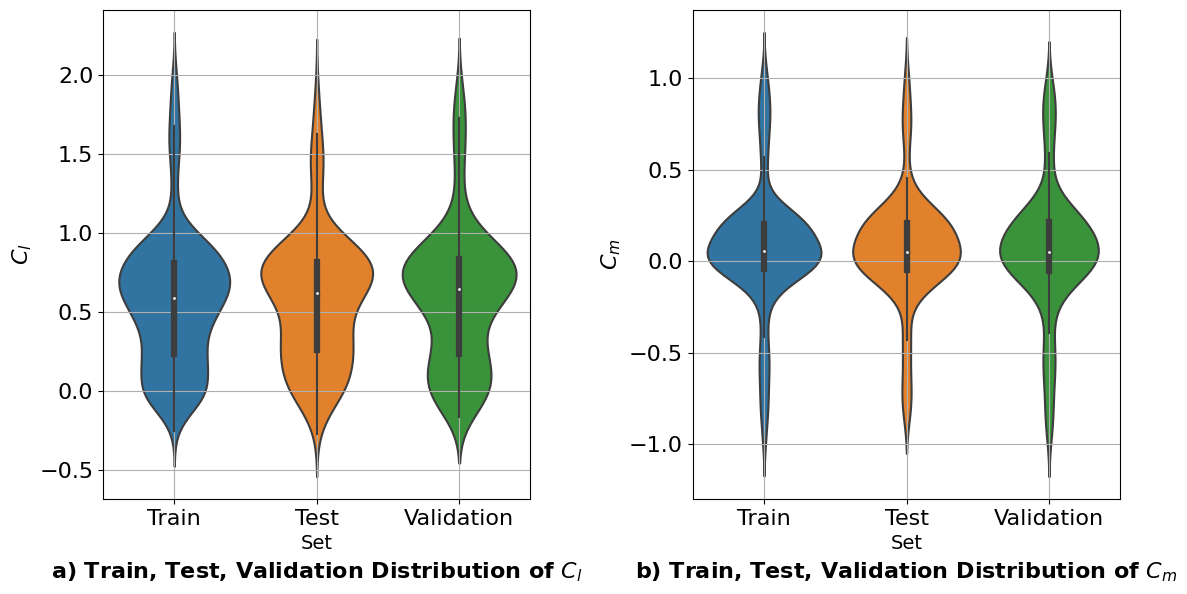

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have y_train, y_test, and y_val DataFrames with 'Cl' and 'Cm' columns

# Combining the data for plotting
combined_data = pd.concat([
    y_train.assign(Set='Train'),
    y_test.assign(Set='Test'),
    y_val.assign(Set='Validation')
])

# Setting up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First subplot for 'Cl'
sns.violinplot(x='Set', y='Cl', data=combined_data, ax=axes[0])
axes[0].set_xlabel('Set', fontsize=14)
axes[0].set_ylabel('$C_l$', fontsize=16)
axes[0].tick_params(axis='x', labelsize=16)  # Set x-label font size
axes[0].tick_params(axis='y', labelsize=16)  # Set y-label font size
axes[0].grid()
axes[0].text(0.5, -0.15, 'a) Train, Test, Validation Distribution of $C_l$', ha='center', va='center', fontsize=16, transform=axes[0].transAxes,fontweight='bold')

# Second subplot for 'Cm'
sns.violinplot(x='Set', y='Cm', data=combined_data, ax=axes[1])
axes[1].set_xlabel('Set', fontsize=14)
axes[1].set_ylabel('$C_m$', fontsize=16)
axes[1].tick_params(axis='x', labelsize=16)  # Set x-label font size
axes[1].tick_params(axis='y', labelsize=16)  # Set y-label font size
axes[1].grid()
axes[1].text(0.5, -0.15, 'b) Train, Test, Validation Distribution of $C_m$', ha='center', va='center', fontsize=16, transform=axes[1].transAxes,fontweight='bold')

plt.tight_layout()  # Adjusts the plots to prevent overlap
plt.show()



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have y_train, y_test, and y_val DataFrames with 'Cl' and 'Cm' columns

# Rename columns to use LaTeX formatted names
y_train = y_train.rename(columns={'Cl': '$C_l$', 'Cm': '$C_m$'})
y_test = y_test.rename(columns={'Cl': '$C_l$', 'Cm': '$C_m$'})
y_val = y_val.rename(columns={'Cl': '$C_l$', 'Cm': '$C_m$'})

# Combining the data for plotting
combined_data = pd.concat([
    y_train.assign(Set='Train'),
    y_test.assign(Set='Test'),
    y_val.assign(Set='Validation')
])

# Setting up the matplotlib figure
plt.figure(figsize=(12, 6))

# First subplot for 'Cl' (now '$C_l$')
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
sns.violinplot(x='Set', y='$C_l$', data=combined_data)
plt.title('Violin Plot of $C_l$ Distribution')
plt.grid()

# Second subplot for 'Cm' (now '$C_m$')
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
sns.violinplot(x='Set', y='$C_m$', data=combined_data)
plt.title('Violin Plot of $C_m$ Distribution')
plt.grid()

plt.tight_layout()  # Adjusts the plots to prevent overlap
plt.show()


NameError: ignored

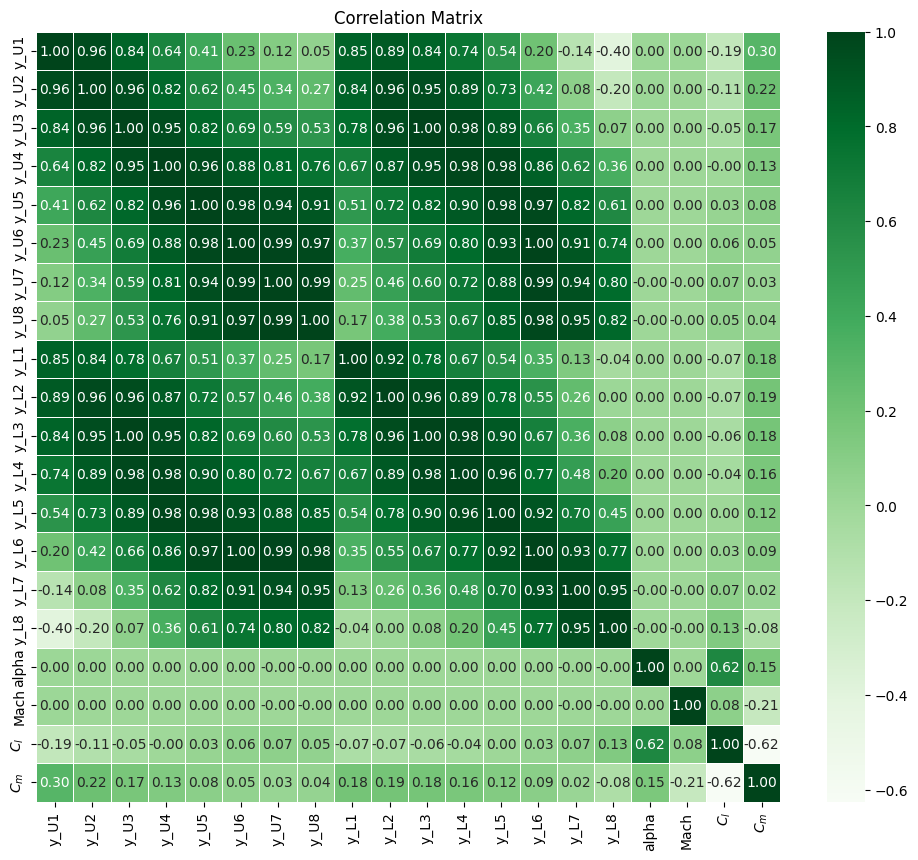

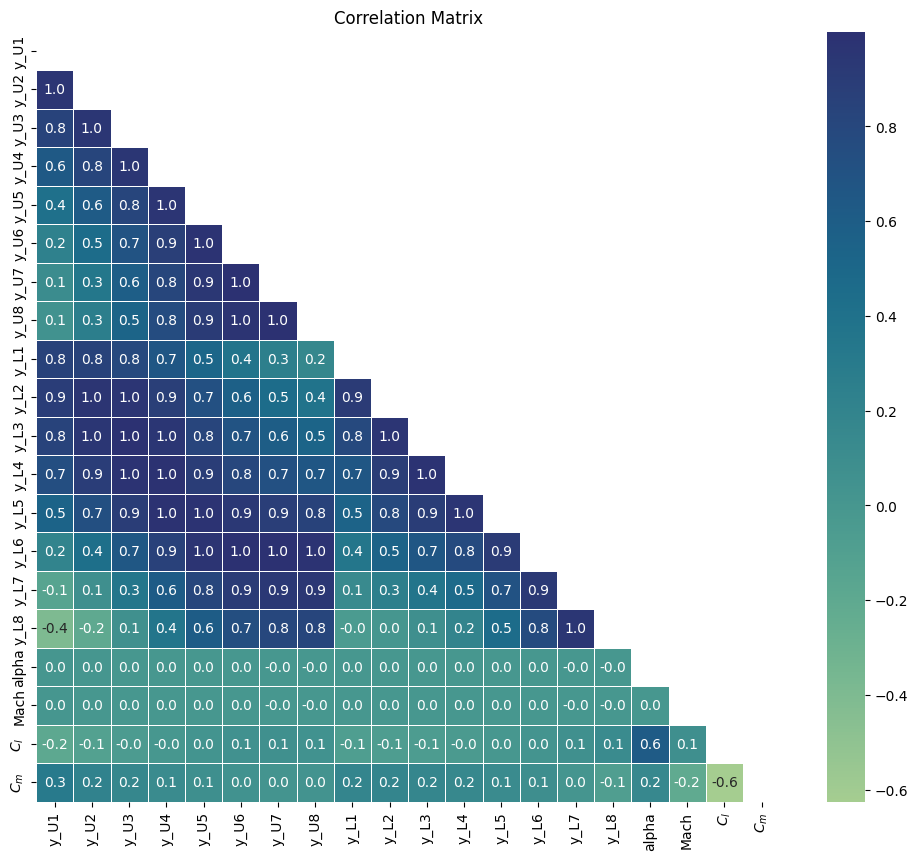

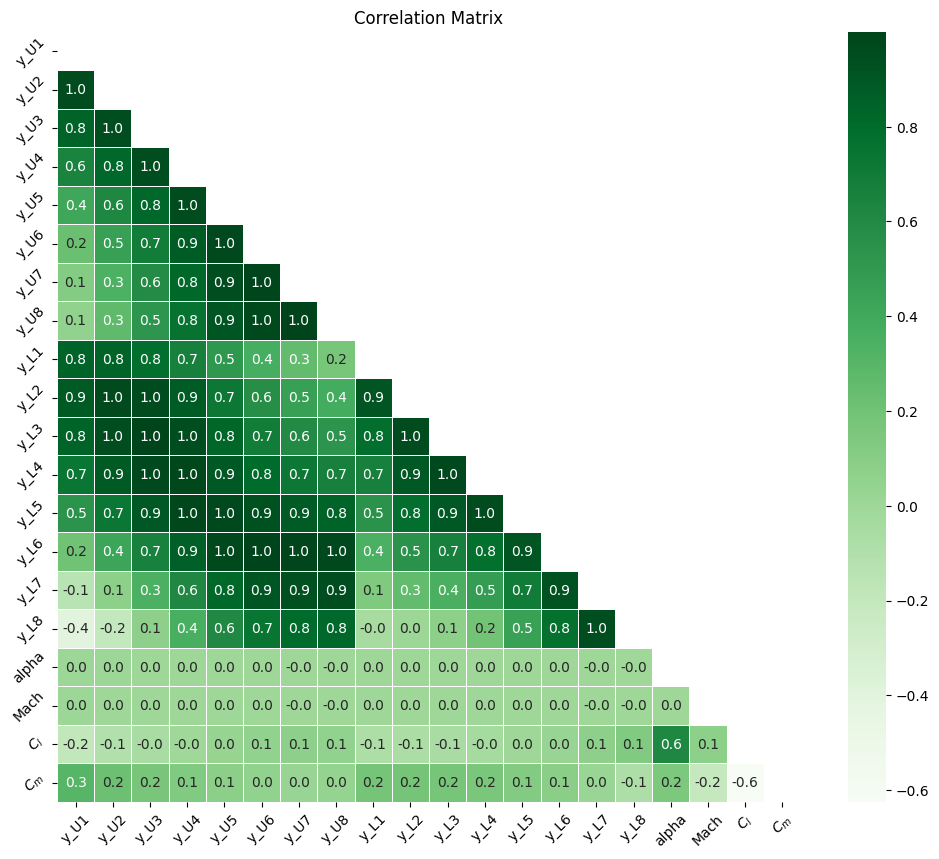

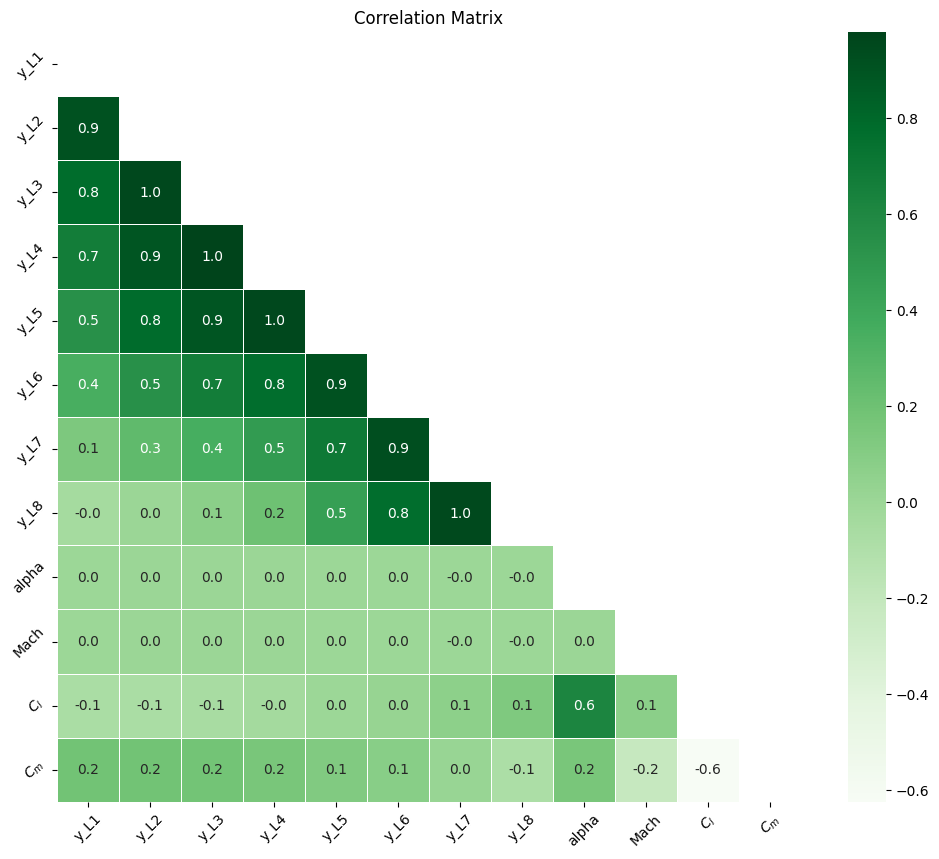

In [ ]:
import pandas as pd
import  numpy as np
# Load the CSV file
csv_file_path = '/content/drive/MyDrive/DATA_MODIFIED.csv'
df = pd.read_csv(csv_file_path)
# Update column names with LaTeX-style formatting
df.rename(columns={
    'Cl': '$C_l$',
    'Cm': '$C_m$',
    # Add other columns here as needed
}, inplace=True)

correlation_matrix = df.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()





# Compute the correlation matrix
correlation_matrix = df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='crest' , fmt=".1f", linewidths=.5, mask=mask)
plt.title("Correlation Matrix")
plt.show()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt=".1f", linewidths=.5, mask=mask)
plt.title("Correlation Matrix")
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.yticks(rotation=45)  # Rotate y labels for better readability
plt.show()




# Filter the DataFrame and the correlation matrix
filtered_df = df.iloc[:, 8:]
filtered_correlation_matrix = filtered_df.corr()
mask = np.triu(np.ones_like(filtered_correlation_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_correlation_matrix, annot=True, cmap='Greens', fmt=".1f", linewidths=.5, mask=mask)
plt.title("Correlation Matrix")
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.yticks(rotation=45)  # Rotate y labels for better readability
plt.show()





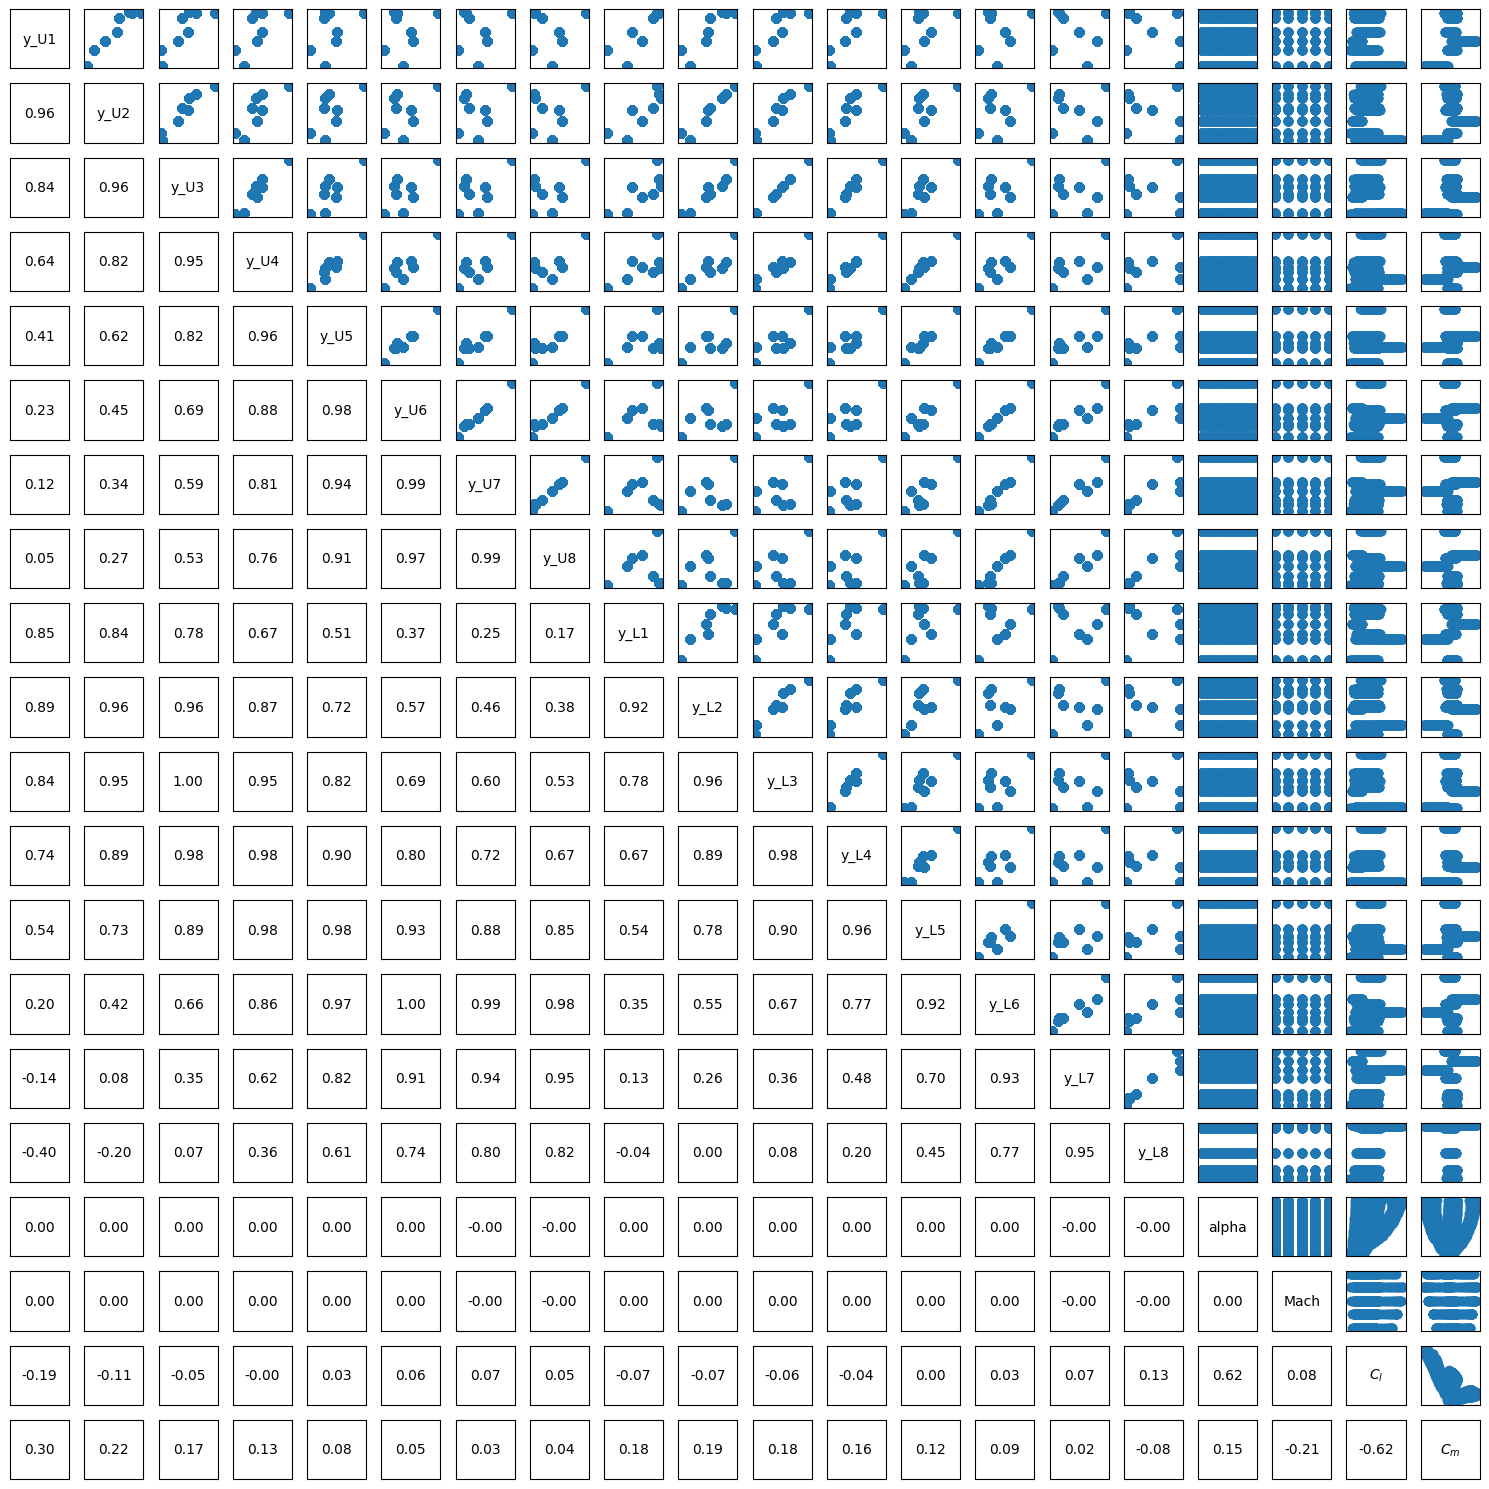

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

csv_file_path = '/content/drive/MyDrive/DATA_MODIFIED.csv'
df = pd.read_csv(csv_file_path)
# Update column names with LaTeX-style formatting
df.rename(columns={
    'Cl': '$C_l$',
    'Cm': '$C_m$',
    # Add other columns here as needed
}, inplace=True)

# Compute the correlation matrix
corr_matrix = df.corr()

# Initialize the matplotlib figure
fig, axs = plt.subplots(len(df.columns), len(df.columns), figsize=(15, 15))

# Iterate over rows and columns to fill in the subplots
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):

        # For upper triangle, plot scatter
        if i < j:
            axs[i, j].scatter(df.iloc[:, j], df.iloc[:, i])
            axs[i, j].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

        # For diagonal, show the variable name
        elif i == j:
            axs[i, j].text(0.5, 0.5, corr_matrix.columns[i], ha='center', va='center')
            axs[i, j].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

        # For lower triangle, show the correlation coefficient
        else:
            axs[i, j].text(0.5, 0.5, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center')
            axs[i, j].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.tight_layout()
plt.show()


In [ ]:
# iterating the columns
for col in df.columns:
    print(col)

y_U1
y_U2
y_U3
y_U4
y_U5
y_U6
y_U7
y_U8
y_L1
y_L2
y_L3
y_L4
y_L5
y_L6
y_L7
y_L8
alpha
Mach
$C_l$
$C_m$


In [ ]:
df.head()

,y_U1,y_U2,y_U3,y_U4,y_U5,y_U6,y_U7,y_U8,y_L1,y_L2,y_L3,y_L4,y_L5,y_L6,y_L7,y_L8,alpha,Mach,$C_l$,$C_m$
0,0.0485,0.0584,0.0598,0.0562,0.0493,0.0401,0.0291,0.0164,-0.0485,-0.0584,-0.0598,-0.0562,-0.0493,-0.0401,-0.0291,-0.0164,-2.0,0.65,-0.147176,-0.069529
1,0.0485,0.0584,0.0598,0.0562,0.0493,0.0401,0.0291,0.0164,-0.0485,-0.0584,-0.0598,-0.0562,-0.0493,-0.0401,-0.0291,-0.0164,-1.5,0.65,-0.108013,-0.052130
2,0.0485,0.0584,0.0598,0.0562,0.0493,0.0401,0.0291,0.0164,-0.0485,-0.0584,-0.0598,-0.0562,-0.0493,-0.0401,-0.0291,-0.0164,-1.0,0.65,-0.069634,-0.034565
3,0.0485,0.0584,0.0598,0.0562,0.0493,0.0401,0.0291,0.0164,-0.0485,-0.0584,-0.0598,-0.0562,-0.0493,-0.0401,-0.0291,-0.0164,-0.5,0.65,-0.031036,-0.017236
4,0.0485,0.0584,0.0598,0.0562,0.0493,0.0401,0.0291,0.0164,-0.0485,-0.0584,-0.0598,-0.0562,-0.0493,-0.0401,-0.0291,-0.0164,0.0,0.65,0.006904,-0.000216


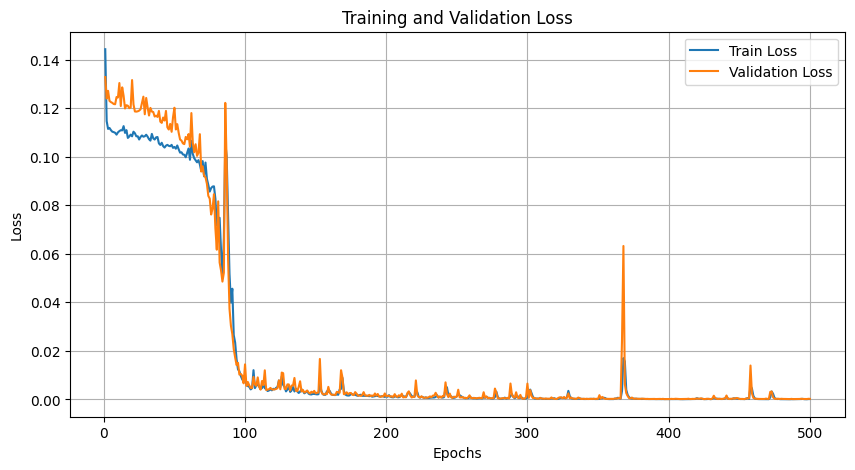

In [ ]:
import matplotlib.pyplot as plt

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RegressionNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Neural Network Training and Validation Loop
num_epochs = 500
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation step
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

# Plotting the learning curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


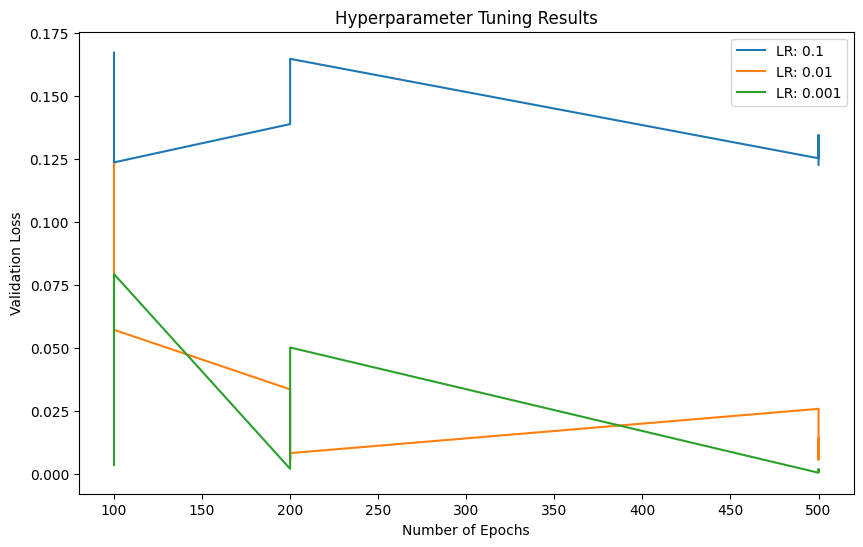

In [ ]:
import matplotlib.pyplot as plt

class RegressionNN(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes=(128, 64, 32), output_size=2):
        super(RegressionNN, self).__init__()
        self.layers = nn.ModuleList()
        last_size = input_size

        # Creating hidden layers
        for size in hidden_layer_sizes:
            self.layers.append(nn.Linear(last_size, size))
            last_size = size

        # Output layer
        self.output = nn.Linear(last_size, output_size)

    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))
        x = self.output(x)
        return x

# Hyperparameters to test
learning_rates = [0.1, 0.01, 0.001]
num_epochs_options = [100, 200, 500]
hidden_layer_sizes = [(128, 64, 32), (64, 32, 16), (32, 16, 8)]

# Store the results
results = []

for lr in learning_rates:
    for num_epochs in num_epochs_options:
        for sizes in hidden_layer_sizes:
            # Initialize model with different hidden layer sizes
            model = RegressionNN(input_size=len(features), hidden_layer_sizes=sizes).to(device)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            model.train()
            # Train and validate model
            for epoch in range(num_epochs):
                for inputs, targets in train_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    optimizer.step()

                # Validation step
                val_loss = 0
                with torch.no_grad():
                    for inputs, targets in val_loader:
                        inputs, targets = inputs.to(device), targets.to(device)
                        outputs = model(inputs)
                        val_loss += criterion(outputs, targets).item()
                val_loss /= len(val_loader)
            # Record final validation loss
            results.append({
                'learning_rate': lr,
                'num_epochs': num_epochs,
                'hidden_layer_sizes': sizes,
                'validation_loss': val_loss
            })

# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame(results)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
for lr in learning_rates:
    subset = results_df[results_df['learning_rate'] == lr]
    ax.plot(subset['num_epochs'], subset['validation_loss'], label=f'LR: {lr}')
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Validation Loss')
ax.set_title('Hyperparameter Tuning Results')
ax.legend()
plt.show()


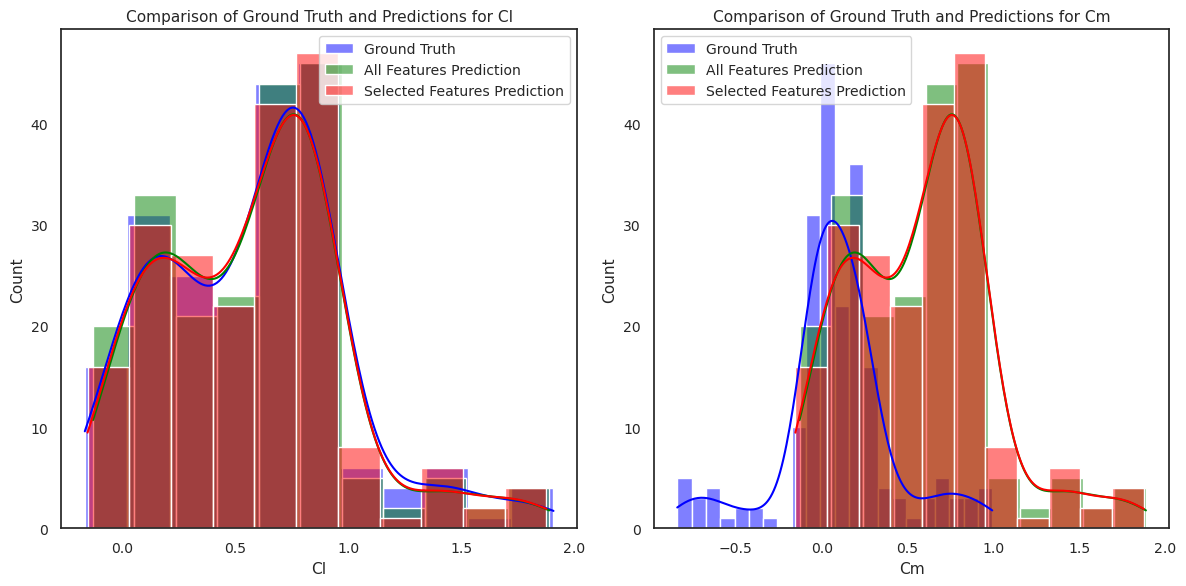

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame 'df' and the train-test split has been done
# X_train, X_test, y_train_cl, y_train_cm, y_test_cl, y_test_cm

# Model with all features
model_all_features = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
model_all_features.fit(X_train, y_train_cl)
pred_cl_all = model_all_features.predict(X_test)
pred_cm_all = model_all_features.predict(X_test)

# Model with selected features
selected_features = ['y_U1', 'y_U2', 'y_L8', 'Mach', 'alpha']
model_selected_features = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
model_selected_features.fit(X_train[selected_features], y_train_cl)
pred_cl_selected = model_selected_features.predict(X_test[selected_features])
pred_cm_selected = model_selected_features.predict(X_test[selected_features])

# Plotting
plt.figure(figsize=(12, 6))

# Plot for Cl
plt.subplot(1, 2, 1)
sns.histplot(y_test_cl, color="blue", label="Ground Truth", kde=True)
sns.histplot(pred_cl_all, color="green", label="All Features Prediction", kde=True)
sns.histplot(pred_cl_selected, color="red", label="Selected Features Prediction", kde=True)
plt.title('Comparison of Ground Truth and Predictions for Cl')
plt.legend()

# Plot for Cm
plt.subplot(1, 2, 2)
sns.histplot(y_test_cm, color="blue", label="Ground Truth", kde=True)
sns.histplot(pred_cm_all, color="green", label="All Features Prediction", kde=True)
sns.histplot(pred_cm_selected, color="red", label="Selected Features Prediction", kde=True)
plt.title('Comparison of Ground Truth and Predictions for Cm')
plt.legend()

plt.tight_layout()
plt.show()


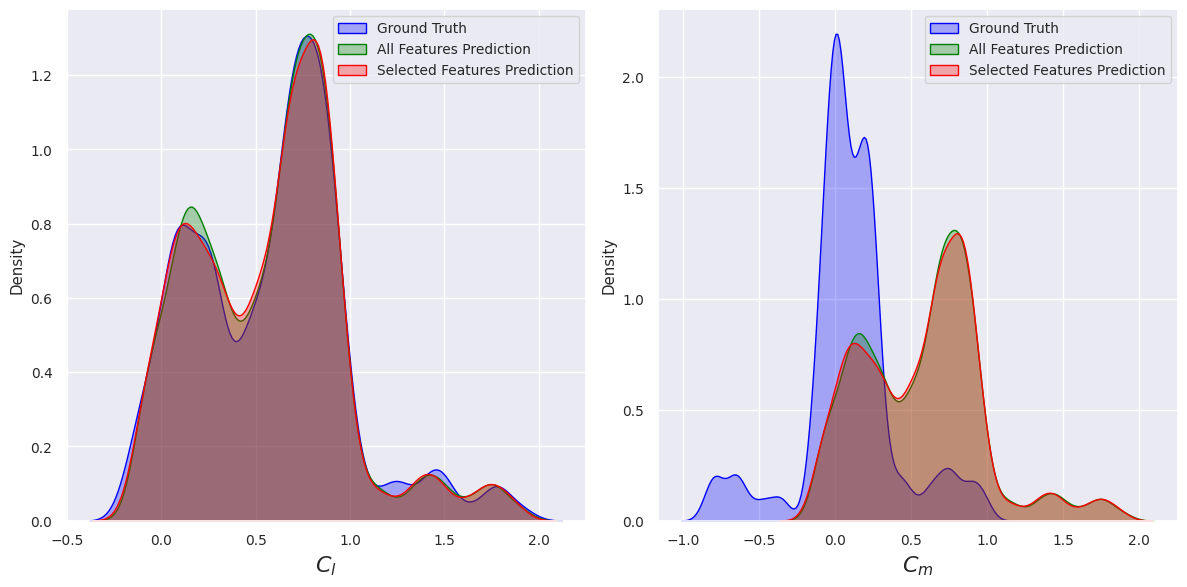

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=0.9)

# Assuming the GradientBoostingRegressor models and predictions are already done
# pred_cl_all, pred_cl_selected, pred_cm_all, pred_cm_selected
# y_test_cl, y_test_cm

# Plotting filled KDE plots
plt.figure(figsize=(12, 6))

# Filled PDF for Cl
plt.subplot(1, 2, 1)
sns.kdeplot(y_test_cl, color="blue", fill=True, alpha=0.3, label="Ground Truth", bw_adjust=0.5)
sns.kdeplot(pred_cl_all, color="green", fill=True, alpha=0.3, label="All Features Prediction", bw_adjust=0.5)
sns.kdeplot(pred_cl_selected, color="red", fill=True, alpha=0.3, label="Selected Features Prediction", bw_adjust=0.5)
plt.xlabel('$C_l$',  fontsize=16)
plt.legend()

# Filled PDF for Cm
plt.subplot(1, 2, 2)
sns.kdeplot(y_test_cm, color="blue", fill=True, alpha=0.3, label="Ground Truth", bw_adjust=0.5)
sns.kdeplot(pred_cm_all, color="green", fill=True, alpha=0.3, label="All Features Prediction", bw_adjust=0.5)
sns.kdeplot(pred_cm_selected, color="red", fill=True, alpha=0.3, label="Selected Features Prediction", bw_adjust=0.5)
plt.xlabel('$C_m$', fontsize=16)
plt.legend()

plt.tight_layout()
plt.show()


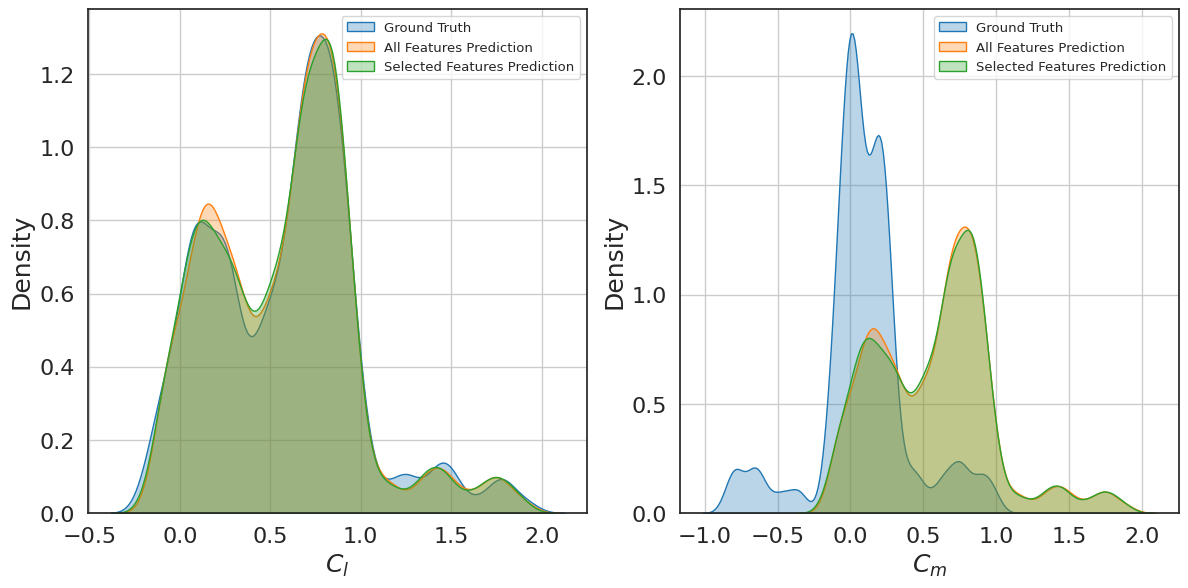

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=0.87)#

# Set the color palette to the default
sns.set_palette("tab10")
sns.set_style("white")

# Get the colors from the current palette
colors = sns.color_palette()

# Assuming the GradientBoostingRegressor models and predictions are already done
# pred_cl_all, pred_cl_selected, pred_cm_all, pred_cm_selected
# y_test_cl, y_test_cm

font_size = 14
# Plotting filled KDE plots with Seaborn's default colors
plt.figure(figsize=(12, 6))

# Filled PDF for Cl
plt.subplot(1, 2, 1)
sns.kdeplot(y_test_cl, color=colors[0], fill=True, alpha=0.3, label="Ground Truth", bw_adjust=0.5)
sns.kdeplot(pred_cl_all, color=colors[1], fill=True, alpha=0.3, label="All Features Prediction", bw_adjust=0.5)
sns.kdeplot(pred_cl_selected, color=colors[2], fill=True, alpha=0.3, label="Selected Features Prediction", bw_adjust=0.5)
#plt.title('PDF Comparison for $C_l$')
plt.xlabel('$C_l$', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.grid()

plt.legend()
# Get the current Axes object and adjust the font size
plt.gca().tick_params(axis='x', labelsize=16)  # Increase font size for x-axis labels
plt.gca().tick_params(axis='y', labelsize=16)  # Increase font size for y-axis labels
# Filled PDF for Cm
plt.subplot(1, 2, 2)
sns.kdeplot(y_test_cm, color=colors[0], fill=True, alpha=0.3, label="Ground Truth", bw_adjust=0.5)
sns.kdeplot(pred_cm_all, color=colors[1], fill=True, alpha=0.3, label="All Features Prediction", bw_adjust=0.5)
sns.kdeplot(pred_cm_selected, color=colors[2], fill=True, alpha=0.3, label="Selected Features Prediction", bw_adjust=0.5)
#plt.title('PDF Comparison for $C_m$')

plt.xlabel('$C_m$', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.grid()
plt.legend()

# Get the current Axes object and adjust the font size
plt.gca().tick_params(axis='x', labelsize=16)  # Increase font size for x-axis labels
plt.gca().tick_params(axis='y', labelsize=16)  # Increase font size for y-axis labels

plt.tight_layout()
plt.show()


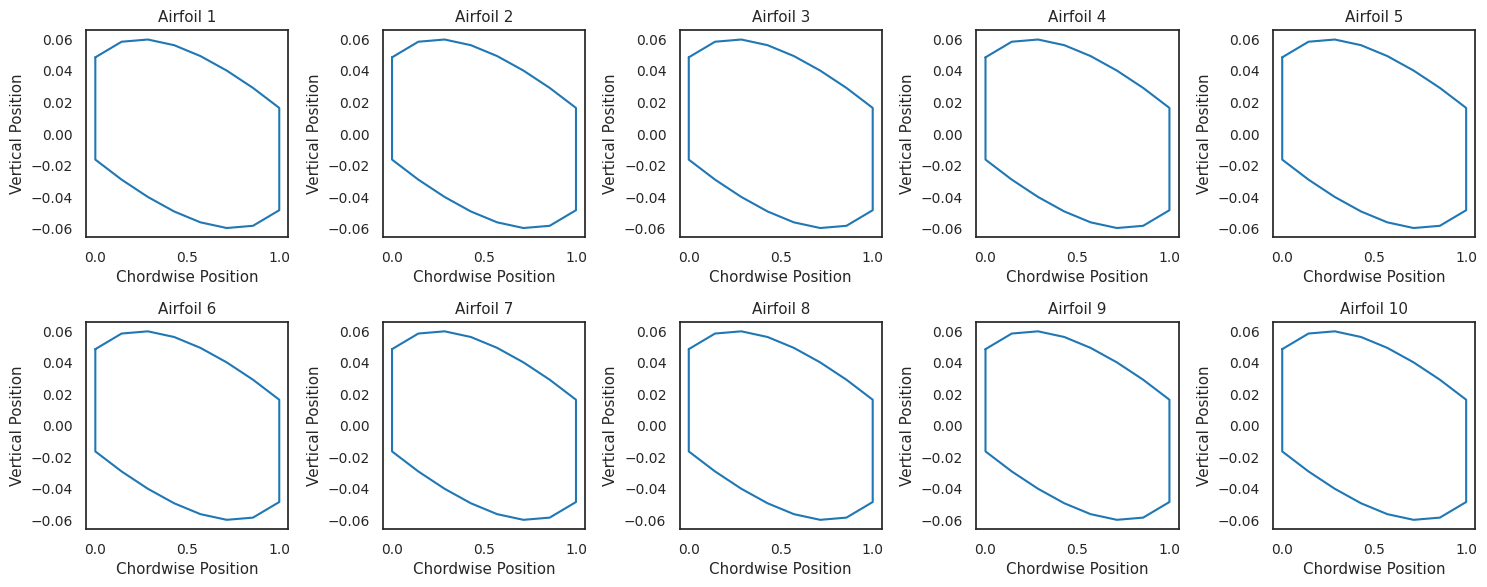

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
csv_file_path = '/content/drive/MyDrive/DATA_MODIFIED.csv'
df = pd.read_csv(csv_file_path)

# Define the features
upper_features = ['y_U1', 'y_U2', 'y_U3', 'y_U4', 'y_U5', 'y_U6', 'y_U7', 'y_U8']
lower_features = ['y_L1', 'y_L2', 'y_L3', 'y_L4', 'y_L5', 'y_L6', 'y_L7', 'y_L8']

# Assuming equal spacing for X-coordinates
x_upper = np.linspace(0, 1, 8)
x_lower = np.linspace(1, 0, 8)  # Reverse for the lower surface

# Set up subplots - 10 subplots in a 2x5 grid
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

# Plotting 10 different airfoils
for i in range(10):
    row = i // 5
    col = i % 5
    ax = axs[row, col]

    # Select an airfoil (you can choose them randomly or sequentially)
    airfoil = df.iloc[i][upper_features + lower_features]

    # Create a closed curve by repeating the first point of the upper surface at the end
    y_values = np.concatenate([airfoil[:8], airfoil[8:], [airfoil[0]]])
    x_values = np.concatenate([x_upper, x_lower, [x_upper[0]]])

    # Plot the airfoil
    ax.plot(x_values, y_values, label=f'Airfoil {i+1}')
    ax.set_title(f'Airfoil {i+1}')
    ax.set_xlabel('Chordwise Position')
    ax.set_ylabel('Vertical Position')

plt.tight_layout()
plt.show()


In [ ]:
#Load the CSV file
csv_file_path = '/content/drive/MyDrive/DATA_MODIFIED.csv'
df = pd.read_csv(csv_file_path)


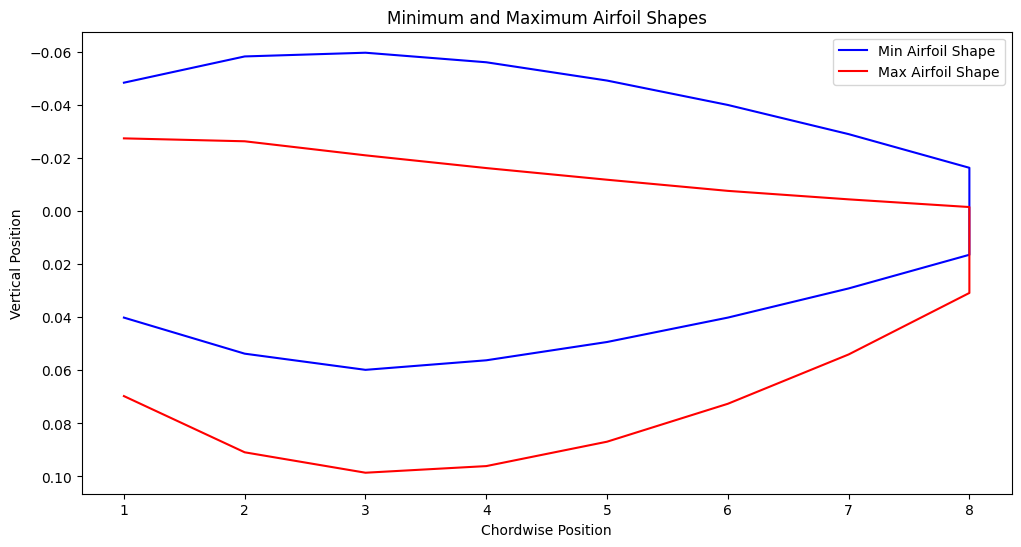

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Load the dataset
csv_file_path = '/content/drive/MyDrive/DATA_MODIFIED.csv'
df = pd.read_csv(csv_file_path)

# Define the features
features_upper = ['y_U1', 'y_U2', 'y_U3', 'y_U4', 'y_U5', 'y_U6', 'y_U7', 'y_U8']
features_lower = ['y_L8', 'y_L7', 'y_L6', 'y_L5', 'y_L4', 'y_L3', 'y_L2', 'y_L1']  # Reversed order

# Calculate the min and max values for each feature
min_values_upper = df[features_upper].min(axis=0)
max_values_upper = df[features_upper].max(axis=0)
min_values_lower = df[features_lower].min(axis=0)
max_values_lower = df[features_lower].max(axis=0)

# Combine upper and lower surfaces for min and max airfoils
min_airfoil = np.concatenate((min_values_upper, min_values_lower))
max_airfoil = np.concatenate((max_values_upper, max_values_lower))

# X-coordinates (assuming equal spacing)
x_coordinates_upper = np.linspace(1, 8, 8)
x_coordinates_lower = np.linspace(8, 1, 8)  # Reversed for the lower surface
x_coordinates = np.concatenate((x_coordinates_upper, x_coordinates_lower))

# Plot the min and max airfoil shapes
plt.figure(figsize=(12, 6))
plt.plot(x_coordinates, min_airfoil, label='Min Airfoil Shape', color='blue')
plt.plot(x_coordinates, max_airfoil, label='Max Airfoil Shape', color='red')
plt.xlabel('Chordwise Position')
plt.ylabel('Vertical Position')
plt.title('Minimum and Maximum Airfoil Shapes')
plt.legend()
plt.gca().invert_yaxis()  # Optional: Invert the Y-axis if required by airfoil coordinate conventions
plt.show()


In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.6 MB/s eta 0:00:00


In [ ]:
from torch import nn, einsum
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat

# helpers
def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

# classes
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

# attention and feedforward
# attention

class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim = -1)
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * mult, dim)
        )

    def forward(self, x, **kwargs):
        return self.net(x)

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        heads = 8,
        dim_head = 16,
        dropout = 0.
    ):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h = self.heads
        q, k, v = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), (q, k, v))
        sim = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = sim.softmax(dim = -1)
        dropped_attn = self.dropout(attn)

        out = einsum('b h i j, b h j d -> b h i d', dropped_attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)', h = h)
        return self.to_out(out), attn

# transformer
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, attn_dropout, ff_dropout):
        super().__init__()
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = attn_dropout)),
                PreNorm(dim, FeedForward(dim, dropout = ff_dropout)),
            ]))

    def forward(self, x, return_attn = False):
        post_softmax_attns = []

        for attn, ff in self.layers:
            attn_out, post_softmax_attn = attn(x)
            post_softmax_attns.append(post_softmax_attn)

            x = x + attn_out
            x = ff(x) + x

        if not return_attn:
            return x

        return x, torch.stack(post_softmax_attns)

# mlp
class MLP(nn.Module):
    def __init__(self, dims, act = None):
        super().__init__()
        dims_pairs = list(zip(dims[:-1], dims[1:]))
        layers = []
        for ind, (dim_in, dim_out) in enumerate(dims_pairs):
            is_last = ind >= (len(dims_pairs) - 1)
            linear = nn.Linear(dim_in, dim_out)
            layers.append(linear)

            if is_last:
                continue

            act = default(act, nn.ReLU())
            layers.append(act)

        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

# main class
class TabTransformer(nn.Module):
    def __init__(
        self,
        num_continuous,
        dim,
        depth,
        heads,
        dim_head = 16,
        dim_out = 1,
        mlp_hidden_mults = (4, 2),
        mlp_act = None,
        attn_dropout = 0.,
        ff_dropout = 0.
    ):
        super().__init__()
        assert num_continuous > 0, 'Input shape must not be null'

        # continuous
        self.num_continuous = num_continuous
        self.norm = nn.LayerNorm(num_continuous)

        # transformer
        self.transformer = Transformer(
            dim = dim,
            depth = depth,
            heads = heads,
            dim_head = dim_head,
            attn_dropout = attn_dropout,
            ff_dropout = ff_dropout
        )

        # mlp to logits
        self.mlp = MLP([dim * num_continuous, *([dim * mult for mult in mlp_hidden_mults]), dim_out], act = mlp_act)

    def forward(self, x_cont, return_attn = False):
        x_cont = x_cont.unsqueeze(1)
        normed_cont = self.norm(x_cont)
        x, attns = self.transformer(normed_cont, return_attn = True)
        x = x.view(x.size(0), -1)
        logits = self.mlp(x)

        if not return_attn:
            return logits

        return logits, attns

